### Downloading all necessary libraries 

In [3]:
import time
import os
import pandas as pd
import numpy as np
import re
import warnings
import statsmodels as sm
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
# import tensorflow_probability as tfp
from scipy.stats import chi2

In [7]:
root_path=r""C:\Fall 2022 courses\Project\Dataset\Dataset\CAIRSENSE_DataFiles.xlsx""

In [8]:
time
path=root_path

xls = pd.ExcelFile(path)
xls_list=xls.sheet_names

df_list=[]

for i in range(len(xls_list)):
  df_list.append(pd.read_excel(path, sheet_name=xls_list[i]))

#### Methods:- Trying to understand the Data generated from the centre. We can see that a total of 10 types of sensor are been installed here to measure different PPC such as O3 , NO, PM etc. To analyze if the anamolies in the data have occured in a specific time period it is necessary to combine data based on common particle of measurement as because each sensor type will have an additional of 2-3 sensor. Therefore the magnitude of variable to measure anamolies will grow more. A standard process can be to combine the variables based on similiar measurement type and then try to analyze data for ananmolies.

In [9]:
df_sensor_info=df_list[0].drop(columns=['Column Heading', 'Contents', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])
df_sensor_info= df_sensor_info.rename(columns={'Sheet Name': 'Sensor Name'})
df_sensor_info

Sensor Name                   Sensor Units       Reference Units
0     Aeroqual                        O3, ppm               O3, ppm
1    AirAssure                   PM2.5, µg/m³          PM2.5, µg/m³
2      Airbeam          Particle Count, hppcf          PM2.5, µg/m³
3     Cairclip                  O3 + NO2, ppb  O3, NO2, O3+NO2, ppb
4     DylosPMC  "Large" Particle Count, hppcf   PM10 - PM2.5, µg/m³
5    Dylos PMF  "Small" Particle Count, hppcf          PM2.5, µg/m³
6       OPCPMF                   PM2.5, µg/m³          PM2.5, µg/m³
7       OPCPMT                    PM10, µg/m³           PM10, µg/m³
8      Shinyei                   PM2.5, µg/m³          PM2.5, µg/m³
9        Speck                   PM2.5, µg/m³          PM2.5, µg/m³
10        TZOA          Particle Count, hppcf          PM2.5, µg/m³

In [10]:
df_factor_info=df_list[0].drop(columns=['Sheet Name', 'Sensor Units','Reference Units', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])
df_factor_info

Column Heading  \
0                            timestamp   
1                                 TEMP   
2                                RHAMB   
3                                   WD   
4                                   WS   
5                                  SoC   
6   Sensor1, etc (e.g. Aeroqual1, etc)   
7                                 SoCP   
8                                SoCO3   
9                               SoCNO2   
10                                 NaN   

                                             Contents  
0                        Measurement timestamp in CST  
1                       Temperature in degrees Celsiu  
2                              Relative Humidity in %  
3                             Wind Direction, degrees  
4                                   Wind Speed in m/s  
5   State of Colorado Reference Monitor Concentration  
6         Sensor Unit 1, etc., Reported Concentration  
7   Combined O3 and NO2 reference concentration (ppb)  
8                    O3 Reference Concentration (ppb)  
9                   NO2 Reference Concentration (ppb)  
10                                                NaN

# Combining different dataset based on common particle measurement

## Creating all necessary class & functions 

In [11]:
class anamoly_detection:

# Create function to change date to datetime format:- 
  def df_to_datetime(self,df):
    try:
      try:
          df=df.rename(columns={'timestamp': 'date'})
          pd.to_datetime(df['date'])
          df=df.set_index('date')
          return df
      except:
            df=pd.to_datetime(df['date'])
            df=df.set_index('date')
            return df
    except:
      print("Error in df_to_datetime")
   
# Function to create dataset
  def create_dataset(self,a):
    try:
            for i in range(len(a)):
                  a[i]=self.df_to_datetime(a[i])
            for i in range(len(a)-1):
                  a[0]=a[0].merge(a[i+1].iloc[:len(a[i+1]),[0,1,2]], how='inner', on='date')
            return a[0]
    except:
          print("Error in create_dataset")

# Function to check null values
  def calc_percentage_NA(self,df):
    nans= pd.DataFrame((df.isnull().sum().sort_values(ascending=False)/len(df))*100, columns=['percent'])
    try:
      idx= nans['percent'] > 0
      return nans[idx]
    except:
      return nans[0]

# Function to handle null values
  def handle_null(self,df):
    try:  
        df=df.drop_duplicates()
        b=[]
        a=df.columns.values
        for i in a:
          if re.findall('date',str(i)):
              pass
          else:
              b.append(i)
          for i in b:
            df[i] = df[i].ewm(halflife=4).mean()
        df=df.dropna()
        return df
    except:
          print("error")

# Function to plot decompose
  def skip_values(self,a):
      skip=['date', 'SoC', 'TEMP', 'RHAMB', 'WS', 'WD', 'SoCO3', 'SoCNO2', 'SOCP']
      if a in skip:
            pass
      else:
        return a

  def plot_decompose(self,df):
    for i in df.columns.values:
      try:
        a=self.skip_values(i)
        df_1=df[a]
        decomposition = sm.tsa.seasonal_decompose(df_1, model='additive', freq=365)
        print(a)
        fig = decomposition.plot()
        plt.show()
      except:
        pass

# # Function to run adfueller test
  def adfueller(self, df):
    for i in df.columns.values:
      try:
        a=self.skip_values(i)
        df_1=df[a]
        result = adfuller(df_1)
        print(a)
        print(result[1])
      except:
          pass

# Function to plot ACF plot
  def plot_ACF(self, df):
    for i in df.columns.values:
      try:
        a=self.skip_values(i)
        df_1=df[a]
        print(a)
        plot_acf(df_1.dropna(), lags=20, alpha=0.05)
      except:
        pass

# Function to plot heatmap for correlation values
  def corr_df(self,df):
      corr = df.corr()
      return sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True) 

# Function to plot pca 
  def plot_pca(self,df, n="None"):
    scaler = StandardScaler()
    pca = PCA(n)
    pipeline = make_pipeline(scaler, pca)
    pipeline.fit(x)
    features = range(pca.n_components_)
    plt.figure(figsize=(15, 5))
    plt.bar(features, pca.explained_variance_)
    plt.xlabel('PCA feature')
    plt.ylabel('Variance')
    plt.xticks(features)
    plt.title("Importance of the Principal Components based on inertia")
    plt.show()

#### Creating custom dataset based on similiar particle measurement.

### Dataset 1:- To measure O3

In [12]:
b=anamoly_detection()

In [61]:
root_path=r"C:\Fall 2022 courses\Project\Multivariate Anamoly Detection\Multivariate-Anamoly-Detection\Saved file"

In [62]:
df_1=df_list[1]
df_1=b.df_to_datetime(df_1)
df_1.to_pickle(root_path+"\df_O3.pkl")
df_O3=pd.read_pickle(root_path+"\df_O3.pkl") 
df_O3

Aeroqual1  Aeroqual2  Aeroqual3    SoC  TEMP  RHAMB
date                                                                    
2015-09-08 23:00:00      0.001        NaN      0.006  0.016  67.5   36.8
2015-09-08 23:01:00      0.006        NaN      0.006  0.022  67.6   36.3
2015-09-08 23:02:00      0.010        NaN      0.012  0.026  67.7   35.8
2015-09-08 23:03:00      0.010        NaN      0.015  0.026  67.8   35.8
2015-09-08 23:04:00      0.012        NaN      0.011  0.024  67.9   35.8
...                        ...        ...        ...    ...   ...    ...
2016-02-22 08:45:00      0.000        0.0      0.000  0.002  36.5   50.4
2016-02-22 08:46:00      0.000        0.0      0.000  0.002  36.8   50.1
2016-02-22 08:47:00      0.000        0.0      0.000  0.002  37.1   50.1
2016-02-22 08:48:00      0.000        0.0      0.000  0.002  37.2   50.1
2016-02-22 08:49:00      0.000        0.0      0.000  0.002  37.3   49.9

[212047 rows x 6 columns]

### Dataset 2:- To measure "**PM2**.5, µg/m³"

In [63]:
a=[df_list[2], df_list[7],df_list[9], df_list[10]]
df_2=b.create_dataset(a)
df_2.to_pickle(root_path+"\df_PM.pkl")
df_PM=pd.read_pickle(root_path+"\df_PM.pkl")
df_PM

AirAssure1  AirAssure2  AirAssure3  TEMP   SoC  RHAMB  \
date                                                                         
2015-09-09 11:00:00       9.654       5.830       7.197  85.3   3.9    8.7   
2015-09-09 11:01:00       9.708       5.809       7.086  85.5   4.1    8.5   
2015-09-09 11:02:00       9.621       5.728       7.275  85.2   4.0    8.2   
2015-09-09 11:03:00       9.595       5.794       7.825  85.2   4.9    8.2   
2015-09-09 11:04:00      10.491       6.715       8.157  84.8   4.0    8.0   
...                         ...         ...         ...   ...   ...    ...   
2016-02-22 08:45:00      17.763      16.783      15.630  36.5  14.7   50.4   
2016-02-22 08:46:00      17.634      17.129      16.177  36.8  17.9   50.1   
2016-02-22 08:47:00      18.037      17.086      16.985  37.1  18.4   50.1   
2016-02-22 08:48:00      16.870      17.071      17.648  37.2  16.9   50.1   
2016-02-22 08:49:00      17.778      16.567      17.648  37.3  17.3   49.9   

                         OPC1      OPC2  OPC3  Shinyei1  Shinyei2  Shinyei3  \
date                                                                          
2015-09-09 11:00:00  1.578333  2.048333   0.0     3.312       NaN     5.130   
2015-09-09 11:01:00  1.585000  1.975000   0.0     5.076       NaN     3.744   
2015-09-09 11:02:00  2.203333  2.316667   0.0     3.492       NaN     3.978   
2015-09-09 11:03:00  1.736667  2.536667   0.0     3.798       NaN     5.184   
2015-09-09 11:04:00  1.651667  2.070000   0.0     5.796       NaN     5.058   
...                       ...       ...   ...       ...       ...       ...   
2016-02-22 08:45:00  4.313333  0.441667   NaN     5.544    10.267     7.776   
2016-02-22 08:46:00  3.696667  0.420000   NaN     5.490    10.258     7.866   
2016-02-22 08:47:00  4.031667  0.421667   NaN     7.128    10.221     7.758   
2016-02-22 08:48:00  4.323333  0.235000   NaN     7.812    10.234     8.874   
2016-02-22 08:49:00  7.775000  0.241667   NaN     6.678    10.218     8.226   

                     Speck1  Speck2  Speck3  
date                                         
2015-09-09 11:00:00    15.1    16.0    15.1  
2015-09-09 11:01:00    13.8    16.2    13.2  
2015-09-09 11:02:00    13.0    15.4    13.1  
2015-09-09 11:03:00    14.0    15.2    13.6  
2015-09-09 11:04:00    15.9    14.6    12.7  
...                     ...     ...     ...  
2016-02-22 08:45:00    32.5    36.3    27.2  
2016-02-22 08:46:00    35.3    39.7    29.5  
2016-02-22 08:47:00    36.6    40.2    28.7  
2016-02-22 08:48:00    35.1    40.8    26.9  
2016-02-22 08:49:00    34.7    41.9    27.3  

[184927 rows x 15 columns]

## Dataset 3:- TO measure partcile count hppcf

In [64]:
a=[df_list[3], df_list[5], df_list[6], df_list[11]]
df_3=b.create_dataset(a)
df_3.to_pickle(root_path+"\df_hppcf.pkl")
df_hppcf=pd.read_pickle(root_path+"\df_hppcf.pkl")
df_hppcf

Airbeam1  Airbeam2  Airbeam3  TEMP   SoC  RHAMB  \
date                                                                   
2015-09-08 23:00:00   1855.94       NaN       NaN  67.5   6.8   36.8   
2015-09-08 23:01:00   1835.57       NaN       NaN  67.6   6.6   36.3   
2015-09-08 23:02:00   1996.74       NaN       NaN  67.7   6.9   35.8   
2015-09-08 23:03:00   1711.92       NaN       NaN  67.8   6.1   35.8   
2015-09-08 23:04:00   2075.87       NaN       NaN  67.9   5.8   35.8   
...                       ...       ...       ...   ...   ...    ...   
2016-01-05 09:05:00   3307.90   4249.11   3731.54  35.4  19.1   48.5   
2016-01-05 09:06:00   3466.31   4123.73   4267.04  35.4  17.4   48.0   
2016-01-05 09:07:00   3550.35   4342.66   4567.48  35.4  21.6   47.8   
2016-01-05 09:08:00   3886.86   4136.23   4146.30  35.4  17.2   47.5   
2016-01-05 09:09:00   3738.65   3967.42   4935.86  35.5  20.0   47.3   

                     Dylos1_x  Dylos2_x  Dylos3_x  Dylos1_y  Dylos2_y  \
date                                                                    
2015-09-08 23:00:00      21.0     110.0       NaN     213.0    1298.0   
2015-09-08 23:01:00      19.0      92.0       NaN     219.0    1320.0   
2015-09-08 23:02:00      15.0      72.0       NaN     191.0    1276.0   
2015-09-08 23:03:00      11.0      78.0       NaN     189.0    1206.0   
2015-09-08 23:04:00      12.0      83.0       NaN     185.0    1215.0   
...                       ...       ...       ...       ...       ...   
2016-01-05 09:05:00      90.0     416.0     409.0     967.0    3815.0   
2016-01-05 09:06:00      93.0     409.0     392.0     957.0    3816.0   
2016-01-05 09:07:00     100.0     446.0     428.0    1009.0    3902.0   
2016-01-05 09:08:00     114.0     518.0     474.0    1066.0    3902.0   
2016-01-05 09:09:00      93.0     481.0     424.0    1016.0    3966.0   

                     Dylos3_y        TZOA1      TZOA2      TZOA3  
date                                                              
2015-09-08 23:00:00       NaN   102.250000  84.750000  74.250000  
2015-09-08 23:01:00       NaN   105.500000  82.583333  76.166667  
2015-09-08 23:02:00       NaN    97.250000  81.833333  77.666667  
2015-09-08 23:03:00       NaN   103.083333  79.583333  68.166667  
2015-09-08 23:04:00       NaN    92.416667  78.916667  72.250000  
...                       ...          ...        ...        ...  
2016-01-05 09:05:00    3769.0  1021.666667        NaN        NaN  
2016-01-05 09:06:00    3753.0  1043.333333        NaN        NaN  
2016-01-05 09:07:00    3863.0  1053.750000        NaN        NaN  
2016-01-05 09:08:00    3852.0  1057.500000        NaN        NaN  
2016-01-05 09:09:00    3914.0  1062.545455        NaN        NaN  

[103142 rows x 15 columns]

## Dataset 4:- O3 & N2

In [65]:
a=df_list[4]
df_4=b.df_to_datetime(a)
df_4=df_4.drop(columns=['Cairclip1'])
df_4.to_pickle(root_path+"\df_O3_NO.pkl")
df_O3_NO=pd.read_pickle(root_path+"\df_O3_NO.pkl")
df_O3_NO

Cairclip2  Cairclip3  TEMP  RHAMB  SOCP  SoCO3  SoCNO2
date                                                                       
2015-09-08 23:00:00        NaN       10.0  67.5   36.8  42.3   16.0    26.3
2015-09-08 23:01:00        NaN       10.0  67.6   36.3  42.9   22.0    20.9
2015-09-08 23:02:00        NaN       14.0  67.7   35.8  45.6   26.0    19.6
2015-09-08 23:03:00        NaN       13.0  67.8   35.8  45.6   26.0    19.6
2015-09-08 23:04:00        NaN       15.0  67.9   35.8  43.7   24.0    19.7
...                        ...        ...   ...    ...   ...    ...     ...
2016-02-22 08:45:00       17.0       27.0  36.5   50.4  48.0    2.0    46.0
2016-02-22 08:46:00       15.0       25.0  36.8   50.1  50.7    2.0    48.7
2016-02-22 08:47:00       13.0       22.0  37.1   50.1  52.9    2.0    50.9
2016-02-22 08:48:00       12.0       20.0  37.2   50.1  51.7    2.0    49.7
2016-02-22 08:49:00       17.0       22.0  37.3   49.9  52.1    2.0    50.1

[212035 rows x 7 columns]

## Dataset 5:- to measure PM10

In [66]:
a=df_list[8]
df_5=b.df_to_datetime(a)
df_5.to_pickle(root_path+"\df_PMO.pkl")
df_PMO=pd.read_pickle(root_path+"\df_PMO.pkl")
df_PMO

OPC1      OPC2  OPC3  TEMP   SoC  RHAMB
date                                                             
2015-09-09 11:00:00   8.996667  6.451667   0.0  85.3  12.0    8.7
2015-09-09 11:01:00   8.743333  9.783333   0.0  85.5  14.3    8.5
2015-09-09 11:02:00   8.693333  4.301667   0.0  85.2   9.0    8.2
2015-09-09 11:03:00   8.326667  6.790000   0.0  85.2  10.7    8.2
2015-09-09 11:04:00   7.120000  5.870000   0.0  84.8   6.9    8.0
...                        ...       ...   ...   ...   ...    ...
2016-02-22 10:54:00  13.633333       NaN   NaN  46.5  32.2   24.2
2016-02-22 10:55:00  19.318333       NaN   NaN  47.1  36.7   23.9
2016-02-22 10:56:00  20.550000       NaN   NaN  46.8  45.9   24.0
2016-02-22 10:57:00  16.415000       NaN   NaN  46.9  40.4   24.2
2016-02-22 10:58:00  13.475000       NaN   NaN  46.3  40.1   23.7

[208059 rows x 6 columns]

# EDA
## Data imputation & Feature Engineering :- 
#### Remove redundant columns
#### Remove duplicates
#### Handle missing values
#### Convert data types to the correct data type

#### Dataset 1

In [67]:
b.calc_percentage_NA(df_O3)

percent
Aeroqual2  16.735441
Aeroqual3   7.532764
Aeroqual1   6.394337
SoC         2.562639
TEMP        0.716351
RHAMB       0.691356

In [68]:
df_O3=b.handle_null(df_O3)
b.calc_percentage_NA(df_O3)

Empty DataFrame
Columns: [percent]
Index: []

##### Dataset 2

In [69]:
b.calc_percentage_NA(df_O3_NO)

percent
Cairclip2  27.713821
Cairclip3  26.807367
SOCP        6.868677
SoCNO2      5.095857
SoCO3       2.562313
TEMP        0.716391
RHAMB       0.691395

In [70]:
df_O3_NO=b.handle_null(df_O3_NO)
b.calc_percentage_NA(df_O3_NO)

Empty DataFrame
Columns: [percent]
Index: []

#### Dataset 3:-

In [71]:
b.calc_percentage_NA(df_PM)

percent
OPC3      19.506075
Shinyei2  17.814597
OPC1      15.986849
OPC2      12.846691
Speck2    10.974060
Speck1    10.872398
Shinyei1   5.395102
TEMP       0.815457
SoC        0.804101
RHAMB      0.786256
Speck3     0.779767
Shinyei3   0.008652

In [72]:
df_PM=b.handle_null(df_PM)
b.calc_percentage_NA(df_PM)

Empty DataFrame
Columns: [percent]
Index: []

#### Dataset 4:- 

In [73]:
b.calc_percentage_NA(df_PMO)

percent
OPC3   21.604449
OPC2   15.684013
OPC1   14.669397
TEMP    0.727198
SoC     0.716624
RHAMB   0.701724

In [74]:
df_PMO=b.handle_null(df_PMO)
b.calc_percentage_NA(df_PMO)

Empty DataFrame
Columns: [percent]
Index: []

#### Dataset 5:-

In [75]:
b.calc_percentage_NA(df_hppcf)

percent
Airbeam3  30.047895
Airbeam2  29.981967
TZOA2     19.508057
TZOA3     19.470245
Dylos3_x  18.823564
Dylos3_y  18.652925
Dylos2_x   4.930096
Dylos1_x   4.825386
Dylos2_y   4.813752
Dylos1_y   4.738128
Airbeam1   4.633418
TEMP       1.460123
SoC        1.426189
RHAMB      1.405829
TZOA1      0.006787

In [76]:
df_hppcf=b.handle_null(df_hppcf)
b.calc_percentage_NA(df_hppcf)

Empty DataFrame
Columns: [percent]
Index: []

# Stationary and Autocorrelation

#### Before we proceed with any type of modelling we need to check for stationarity of data. If data has seonsanility then we won't be able to capture anamolies in data. Seasonality itself will be a point anamoly and also show continuous anamolies if the trends in data exist.

#### We will use the Ad Fueller test. The Ad fueller test has a null hypothesis that there exista unit root in time series and hence it is non stationary. If we get P valuess less than 0.05 then we reject the nulll hypothesis and the data is considered stationary. 

In [ ]:
b.adfueller(df_O3)

Aeroqual1
9.515480073834215e-11
Aeroqual2
3.31918545523431e-27
Aeroqual3
0.0


Here we can see that Aeroqual 3 sensors data is non stationary. Therefore we need to make it stationary before we proceed. 

In [ ]:
df=(pd.DataFrame(np.log(df_O3['Aeroqual3']), columns=['Aeroqual3']))
b.adfueller(df.dropna())

Aeroqual3
3.860456503808098e-30


In [77]:
df_O3['Aeroqual3']=np.log(df_O3['Aeroqual3'])

#### Hence the time series is stationary

In [ ]:
b.adfueller(df_O3_NO)

Cairclip2
1.6980720943164928e-18
Cairclip3
7.455382722625057e-18


In [ ]:
b.adfueller(df_PM)

AirAssure1
0.2009577910201995
AirAssure2
0.00018922841709386975
AirAssure3
0.7259588559163467
OPC1
1.1139148718552327e-28
OPC2
2.9883640767267034e-30
OPC3
0.0
Shinyei1
1.6877309195430772e-20
Shinyei2
1.455639600568339e-24
Shinyei3
0.0
Speck1
1.5272914976964842e-28
Speck2
1.0534570689289514e-20
Speck3
1.0497651762533408e-26


#### Here we can see that Air Assure 1, 2, 3 ,OPC3, Shinyei 3 don't have the stationarity in data.

In [ ]:
df1=(pd.DataFrame(np.log(df_PM['AirAssure1']), columns=['AirAssure1']))
df2=(pd.DataFrame((df_PM['AirAssure2']).shift(1)/(df_PM['AirAssure2']), columns=['AirAssure2']))
df3=(pd.DataFrame(np.sqrt(df_PM['AirAssure3']), columns=['AirAssure3']))
df4=(pd.DataFrame(np.sqrt(df_PM['OPC3']), columns=['OPC3']))
df5=(pd.DataFrame(np.sqrt(df_PM['Shinyei3']).shift(1)/(df_PM['Shinyei3']), columns=['Shinyei3']))
df=pd.concat([df1,df2,df3,df4,df5], axis=1)
b.adfueller(df.dropna())

AirAssure1
0.00023108988847251235
AirAssure2
0.00035131456293419815
AirAssure3
1.0995425678127054e-05
OPC3
1.3534920336047803e-13
Shinyei3
8.112813281829554e-29


In [78]:
df_PM['AirAssure1']=np.log(df_PM['AirAssure1'])
df_PM['AirAssure2']=(df_PM['AirAssure2']).shift(1)/(df_PM['AirAssure2'])
df_PM['AirAssure3']=np.sqrt(df_PM['AirAssure3'])
df_PM['OPC3']=np.sqrt(df_PM['OPC3'])
df_PM['Shinyei3']=np.sqrt(df_PM['Shinyei3']).shift(1)/(df_PM['Shinyei3'])

In [ ]:
b.adfueller(df_PMO)

OPC1
1.4248038555841418e-29
OPC2
1.4576816225034331e-28
OPC3
7.582543042773299e-19


In [ ]:
b.adfueller(df_hppcf)

Airbeam1
0.21357127327383746
Airbeam2
0.3632125267042714
Airbeam3
0.22953738739589163
Dylos1_x
4.739635059008709e-19
Dylos2_x
5.004620115451149e-16
Dylos3_x
6.991132604342137e-17
Dylos1_y
1.0152508075744878e-12
Dylos2_y
1.7757661067662455e-07
Dylos3_y
3.9441675087474397e-07
TZOA1
2.58174572463562e-18
TZOA2
8.154505735574518e-13
TZOA3
5.147174827325817e-13


We can see that Airbeam1, Airbeam2, Airbeam3 have a non stationary data. Therefore there is a need to make it stationary.

In [ ]:
df1=(pd.DataFrame(np.sqrt(np.log(df_hppcf['Airbeam1'])), columns=['Airbeam1']))
df2=(pd.DataFrame(np.log(df_hppcf['Airbeam2']), columns=['Airbeam2']))
df3=(pd.DataFrame(np.log(np.sqrt(df_hppcf['Airbeam3'])), columns=['Airbeam3']))
df=pd.concat([df1,df2,df3], axis=1)
b.adfueller(df)

Airbeam1
2.836001125762836e-08
Airbeam2
4.4438391485128804e-30
Airbeam3
2.9842183761427707e-22


In [79]:
df_hppcf['Airbeam1']=np.sqrt(np.log(df_hppcf['Airbeam1']))
df_hppcf['Airbeam2']=np.log(df_hppcf['Airbeam2'])
df_hppcf['Airbeam3']=np.log(np.sqrt(df_hppcf['Airbeam3']))

Based on all of the above Ad fueller test result we can confidently say that the data is stationary. We can proceed with the further in our EDA to check level of correlation in data. 

##### Saving the new dataset 

In [80]:
## Saving the modified dataframe

df_O3.to_pickle(root_path+"\df_O3_1.pkl")
df_O3=pd.read_pickle(root_path+"\df_O3_1.pkl")

df_O3_NO.to_pickle(root_path+"\df_O3_NO_1.pkl")
df_O3_NO=pd.read_pickle(root_path+"\df_O3_NO_1.pkl")

df_PM.to_pickle(root_path+"\df_PM_1.pkl")
df_PM=pd.read_pickle(root_path+"\df_PM_1.pkl")

df_PMO.to_pickle(root_path+"\df_PMO_1.pkl")
df_PMO=pd.read_pickle(root_path+"\df_PMO_1.pkl")

df_hppcf.to_pickle(root_path+"\df_hppcf_1.pkl")
df_hppcf=pd.read_pickle(root_path+"\df_hppcf_1.pkl")

## Autocorrelation

## Correlation

<AxesSubplot:>

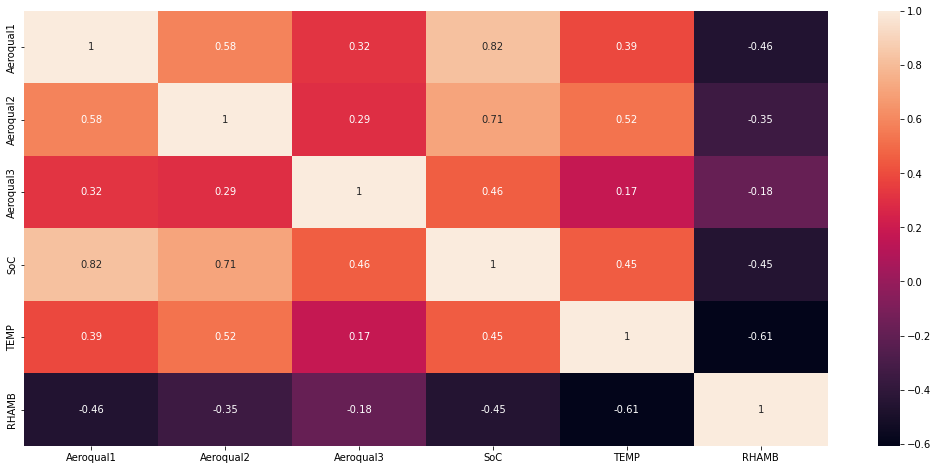

In [ ]:
b.corr_df(df_O3)

<AxesSubplot:>

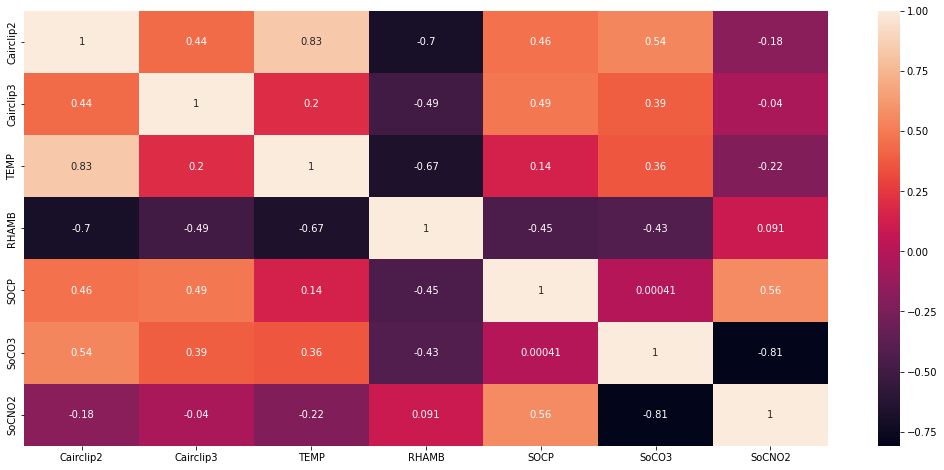

In [ ]:
b.corr_df(df_O3_NO)

<AxesSubplot:>

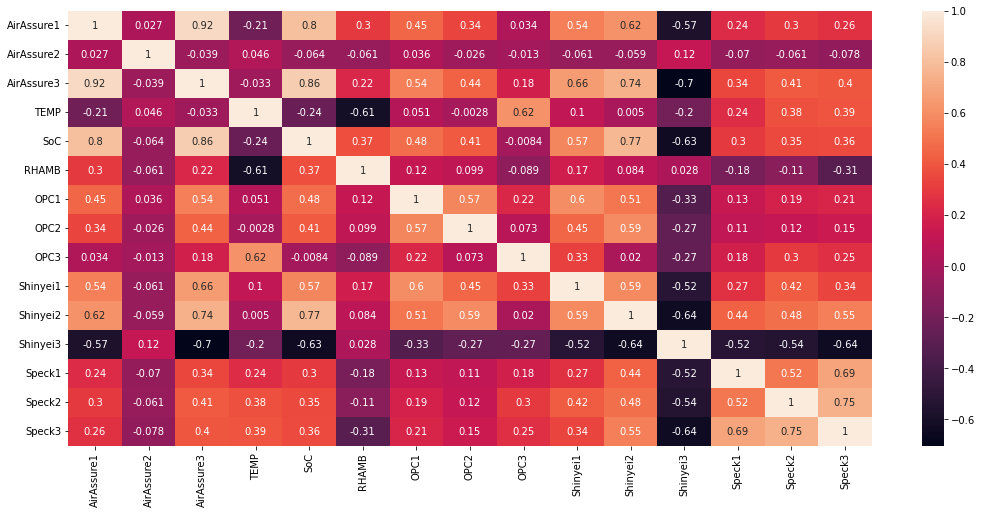

In [ ]:
b.corr_df(df_PM)

<AxesSubplot:>

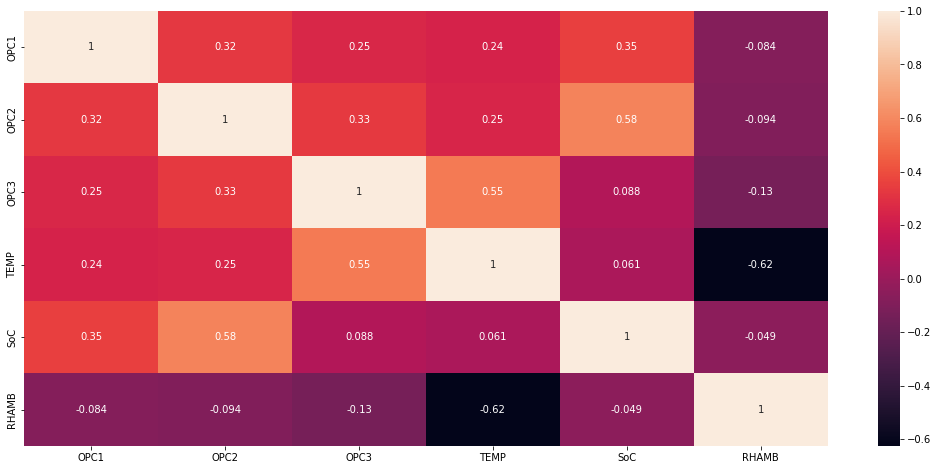

In [ ]:
b.corr_df(df_PMO)

<AxesSubplot:>

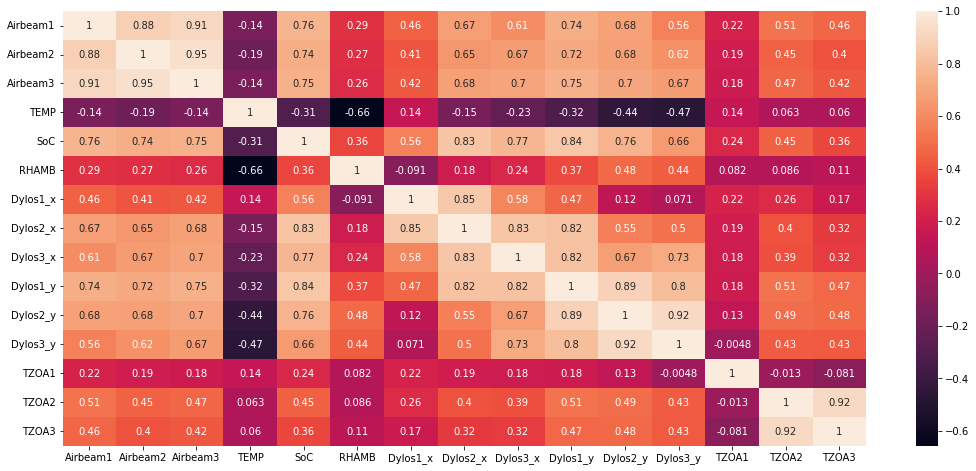

In [ ]:
b.corr_df(df_hppcf)

# Pre-Processing and Dimensionality Reduction (PCA)

### Performing dimensionality reduction on Aeroqual data

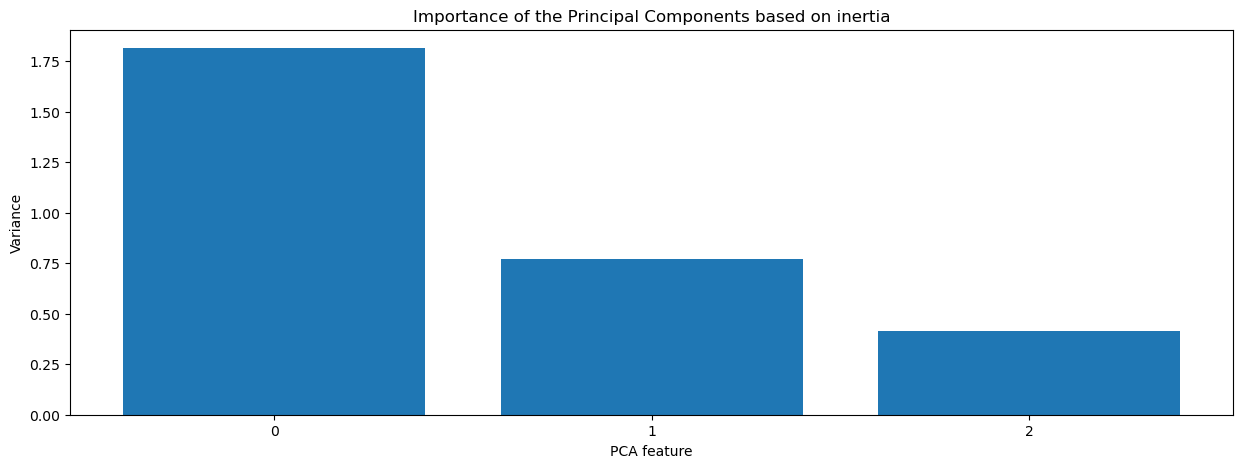

In [81]:
x=df_O3.drop(columns=['SoC', 'TEMP', 'RHAMB'])
b.plot_pca(x,None)

In [82]:
def pca_DF(n,df,x,*args):
  pca = PCA(n_components=n)
  principalComponents = pca.fit_transform(x)
  principal_df = pd.DataFrame(data = principalComponents, columns = [*args])
  df=df.reset_index()
  df=pd.concat([df,principal_df], axis=1)
  df=df.set_index('date')
  return df

In [83]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_O3 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [84]:
df_O3=df_O3.reset_index()
df_O3=pd.concat([df_O3,principal_O3], axis=1)
df_O3=df_O3.set_index('date')
df_O3

Aeroqual1     Aeroqual2  Aeroqual3       SoC  \
date                                                                   
2015-09-09 11:37:00  3.852841e-02  4.100000e-02  -3.185787  0.050241   
2015-09-09 11:38:00  3.861588e-02  4.118920e-02  -3.180832  0.050422   
2015-09-09 11:39:00  3.870652e-02  4.144439e-02  -3.175367  0.050608   
2015-09-09 11:40:00  3.880111e-02  4.174457e-02  -3.169695  0.050782   
2015-09-09 11:41:00  3.890028e-02  4.207124e-02  -3.164181  0.050909   
...                           ...           ...        ...       ...   
2016-02-22 08:44:00  9.403460e-19  8.226211e-20 -45.584173  0.001287   
2016-02-22 08:45:00  8.038044e-19  7.009107e-20 -45.747573  0.001332   
2016-02-22 08:47:00  6.870523e-19  5.971820e-20 -45.911005  0.001376   
2016-02-22 08:48:00  5.872272e-19  5.087825e-20 -46.074470  0.001421   
2016-02-22 08:49:00  5.018796e-19  4.334500e-20 -46.237966  0.001464   

                          TEMP      RHAMB        pc1       pc2  
date                                                            
2015-09-09 11:37:00  85.750590   7.410946  -6.012245  0.042663  
2015-09-09 11:38:00  85.751206   7.393294  -6.017200  0.042861  
2015-09-09 11:39:00  85.750345   7.378451  -6.022665  0.043111  
2015-09-09 11:40:00  85.758587   7.397790  -6.028337  0.043397  
2015-09-09 11:41:00  85.778121   7.461783  -6.033852  0.043705  
...                        ...        ...        ...       ...  
2016-02-22 08:44:00  35.042895  51.893346  36.386155 -0.002057  
2016-02-22 08:45:00  35.138970  51.655750  36.549555 -0.002013  
2016-02-22 08:47:00  35.256547  51.408224  36.712987 -0.001968  
2016-02-22 08:48:00  35.388883  51.200081  36.876452 -0.001924  
2016-02-22 08:49:00  35.530837  50.993234  37.039948 -0.001879  

[189814 rows x 8 columns]

### Performing PCA on Cairclip data 

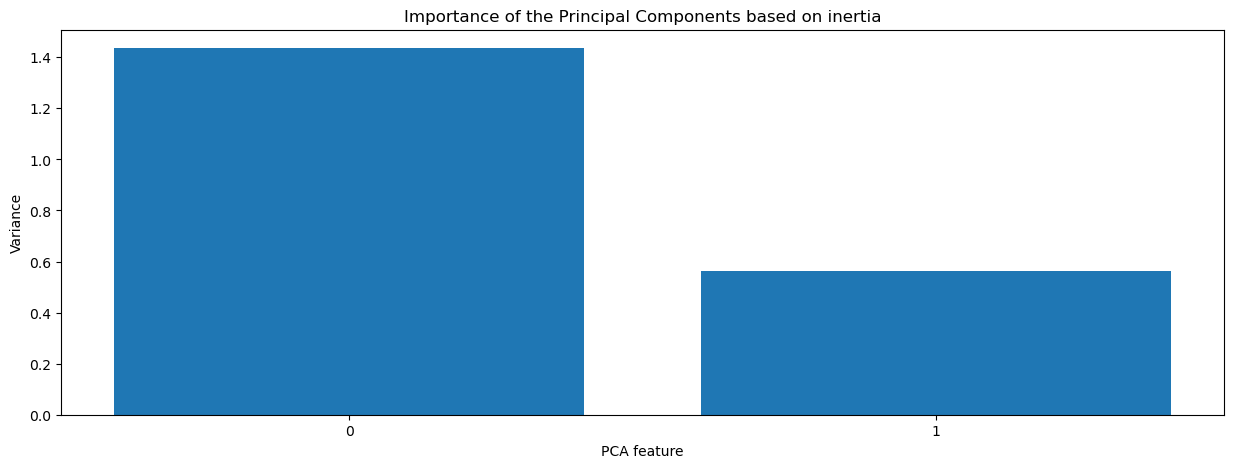

In [85]:
x=df_O3_NO.drop(columns=['SOCP', 'TEMP', 'RHAMB', 'SoCO3', 'SoCNO2'])
b.plot_pca(x,None)

In [86]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_O3_NO = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2'])

In [87]:
df_O3_NO=df_O3_NO.reset_index()
df_O3_NO=pd.concat([df_O3_NO,principal_O3_NO], axis=1)
df_O3_NO=df_O3_NO.set_index('date')
df_O3_NO

Cairclip2  Cairclip3       TEMP      RHAMB       SOCP  \
date                                                                         
2015-10-07 23:00:00  13.000000  16.147038  59.879753  54.708108  35.176458   
2015-10-07 23:01:00  13.069785  15.971091  59.864789  54.706188  35.102850   
2015-10-07 23:02:00  13.139945  15.803289  59.849750  54.704762  35.027590   
2015-10-07 23:03:00  13.210261  15.644275  59.834590  54.704184  34.946608   
2015-10-07 23:04:00  13.280728  15.494588  59.819265  54.704662  34.862285   
...                        ...        ...        ...        ...        ...   
2016-02-22 08:45:00  17.388718  21.448677  34.701709  53.509082  50.492685   
2016-02-22 08:46:00  17.357799  21.368381  34.725379  53.383397  50.418869   
2016-02-22 08:47:00  17.323570  21.289799  34.752122  53.256021  50.362346   
2016-02-22 08:48:00  17.286165  21.214234  34.782421  53.126744  50.325329   
2016-02-22 08:49:00  17.245798  21.142940  34.816729  52.995459  50.309571   

                         SoCO3     SoCNO2       pc1       pc2  
date                                                           
2015-10-07 23:00:00  16.455482  17.753692 -7.991579  0.666412  
2015-10-07 23:01:00  16.487505  17.664199 -8.063179  0.841629  
2015-10-07 23:02:00  16.497809  17.621605 -8.128866  1.011231  
2015-10-07 23:03:00  16.467179  17.618129 -8.188350  1.174607  
2015-10-07 23:04:00  16.433695  17.615217 -8.241262  1.331361  
...                        ...        ...       ...       ...  
2016-02-22 08:45:00   1.663974  47.772852 -1.153641 -0.115145  
2016-02-22 08:46:00   1.689710  47.920365 -1.231572 -0.078674  
2016-02-22 08:47:00   1.715762  48.394436 -1.310703 -0.045733  
2016-02-22 08:48:00   1.741379  48.602156 -1.390034 -0.017168  
2016-02-22 08:49:00   1.766040  48.840468 -1.468539  0.006265  

[169110 rows x 9 columns]

#### Performing dimensionality reduction on AirAssure2 sensor  Data 

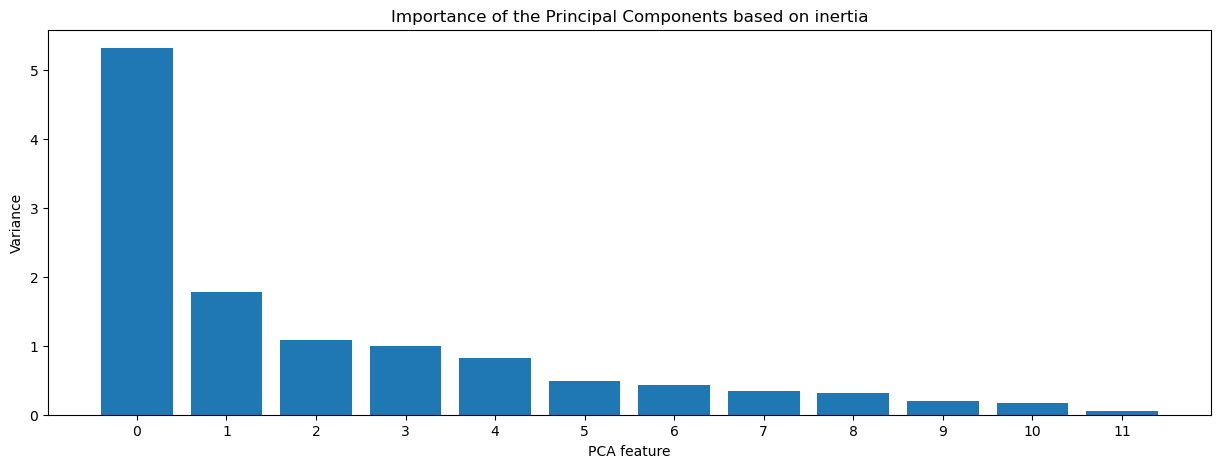

In [88]:
x=df_PM.dropna().drop(columns=['SoC', 'TEMP', 'RHAMB'])
b.plot_pca(x,None)

In [89]:
# Calculate PCA with 2 components
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)
principal_Df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3' , 'pc4', 'pc5', 'pc6'])

In [90]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(principal_Df)
principal_PM = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [91]:
df_PM=df_PM.reset_index()
df_PM=pd.concat([df_PM,principal_PM], axis=1)
df_PM=df_PM.set_index('date')
df_PM

AirAssure1  AirAssure2  AirAssure3       TEMP        SoC  \
date                                                                            
2015-09-09 11:36:00    2.268115         NaN    2.687163  85.271983   3.911539   
2015-09-09 11:37:00    2.268194    0.999786    2.687560  85.266862   3.906000   
2015-09-09 11:38:00    2.268276    0.999780    2.687934  85.261407   3.899643   
2015-09-09 11:39:00    2.268358    0.999777    2.688277  85.255654   3.892459   
2015-09-09 11:40:00    2.268440    0.999779    2.688577  85.249649   3.884444   
...                         ...         ...         ...        ...        ...   
2016-02-22 08:45:00    2.819758    0.994708    3.692508  33.150595  19.273103   
2016-02-22 08:46:00    2.825110    0.995102    3.697387  33.202941  19.192135   
2016-02-22 08:47:00    2.830172    0.995494    3.701955  33.255364  19.108897   
2016-02-22 08:48:00    2.834940    0.995884    3.706248  33.307748  19.023674   
2016-02-22 08:49:00    2.839409    0.996268    3.710302  33.359978  18.936730   

                         RHAMB      OPC1      OPC2          OPC3  Shinyei1  \
date                                                                         
2015-09-09 11:36:00   8.450932  1.567241  1.911609  0.000000e+00  3.618596   
2015-09-09 11:37:00   8.433256  1.560649  1.898959  0.000000e+00  3.597757   
2015-09-09 11:38:00   8.415103  1.553653  1.886226  0.000000e+00  3.577058   
2015-09-09 11:39:00   8.396506  1.546285  1.873468  0.000000e+00  3.556549   
2015-09-09 11:40:00   8.377498  1.538575  1.860732  0.000000e+00  3.536265   
...                        ...       ...       ...           ...       ...   
2016-02-22 08:45:00  57.885146  5.299771  0.436390  1.680095e-08  7.408874   
2016-02-22 08:46:00  57.739241  5.271078  0.451922  1.559032e-08  7.375641   
2016-02-22 08:47:00  57.593299  5.241232  0.471017  1.446625e-08  7.340036   
2016-02-22 08:48:00  57.447477  5.210269  0.493812  1.342260e-08  7.302470   
2016-02-22 08:49:00  57.301913  5.178203  0.520329  1.245368e-08  7.263393   

                      Shinyei2  Shinyei3     Speck1     Speck2     Speck3  \
date                                                                        
2015-09-09 11:36:00   3.190000       NaN  14.083984  12.387771  11.037880   
2015-09-09 11:37:00   3.189149  0.549585  13.941928  12.347702  11.037880   
2015-09-09 11:38:00   3.188205  0.551920  13.749004  12.356237  11.037880   
2015-09-09 11:39:00   3.187175  0.554301  13.517798  12.411570  11.037880   
2015-09-09 11:40:00   3.186026  0.556720  13.266188  12.480810  11.037880   
...                        ...       ...        ...        ...        ...   
2016-02-22 08:45:00  10.581869  0.336015  31.512562  34.102998  26.891311   
2016-02-22 08:46:00  10.589991  0.337171  31.412842  34.257686  27.306363   
2016-02-22 08:47:00  10.596075  0.338261  31.360557  34.517490  27.528096   
2016-02-22 08:48:00  10.600120  0.339269  31.355088  34.860234  27.428163   
2016-02-22 08:49:00  10.602144  0.340194  31.391299  35.280795  27.407772   

                           pc1       pc2  
date                                      
2015-09-09 11:36:00 -13.490348  3.669074  
2015-09-09 11:37:00 -13.611231  3.541932  
2015-09-09 11:38:00 -13.728972  3.363369  
2015-09-09 11:39:00 -13.851431  3.163249  
2015-09-09 11:40:00 -13.970298  2.957630  
...                        ...       ...  
2016-02-22 08:45:00  19.505381  0.863706  
2016-02-22 08:46:00  19.719833  0.692083  
2016-02-22 08:47:00  19.862706  0.522867  
2016-02-22 08:48:00  20.113136  0.338000  
2016-02-22 08:49:00        NaN       NaN  

[184869 rows x 17 columns]

## PCA on dylos dataset

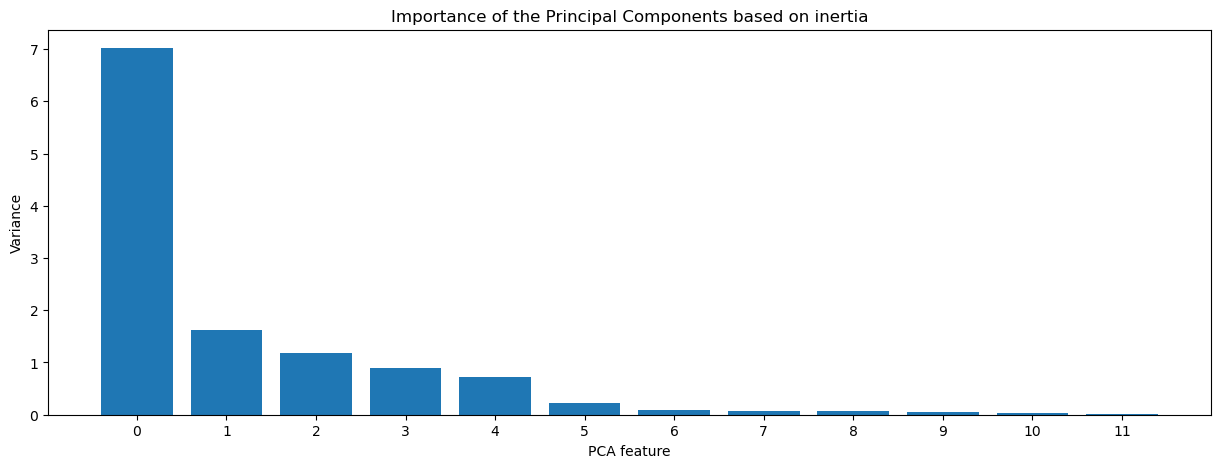

In [92]:
x=df_hppcf.drop(columns=['SoC', 'TEMP', 'RHAMB'])
b.plot_pca(x,None)

In [93]:
# Calculate PCA with 2 components
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principal_Df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3' , 'pc4'])

In [94]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(principal_Df)
principal_hppcf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [95]:
df_hppcf=df_hppcf.reset_index()
df_hppcf=pd.concat([df_hppcf,principal_hppcf], axis=1)
df_hppcf=df_hppcf.set_index('date')
df_hppcf

Airbeam1  Airbeam2  Airbeam3       TEMP        SoC  \
date                                                                      
2015-09-09 11:37:00  2.766475  6.812810  3.649354  78.153448   5.397845   
2015-09-09 11:38:00  2.765042  6.813032  3.649330  78.354148   5.313847   
2015-09-09 11:39:00  2.763537  6.813291  3.649302  78.554415   5.231135   
2015-09-09 11:40:00  2.761960  6.813594  3.649269  78.754014   5.149829   
2015-09-09 11:41:00  2.760311  6.813946  3.649231  78.952718   5.070037   
...                       ...       ...       ...        ...        ...   
2016-01-05 09:05:00  2.866388  8.370265  4.220024  30.821643  19.784130   
2016-01-05 09:06:00  2.866500  8.371212  4.220490  30.867036  19.778737   
2016-01-05 09:07:00  2.866622  8.372186  4.220966  30.913011  19.771474   
2016-01-05 09:08:00  2.866753  8.373180  4.221450  30.959597  19.762524   
2016-01-05 09:09:00  2.866893  8.374192  4.221943  31.006825  19.752084   

                         RHAMB   Dylos1_x    Dylos2_x    Dylos3_x    Dylos1_y  \
date                                                                            
2015-09-09 11:37:00  12.417986  16.444100   70.021312   24.111657  117.455283   
2015-09-09 11:38:00  12.226346  15.888621   68.032449   24.236532  115.546161   
2015-09-09 11:39:00  12.037785  15.353519   66.140928   24.372213  113.751200   
2015-09-09 11:40:00  11.852555  14.838883   64.344562   24.513960  112.063723   
2015-09-09 11:41:00  11.670883  14.344685   62.640817   24.658354  110.477358   
...                        ...        ...         ...         ...         ...   
2016-01-05 09:05:00  59.661989  61.143844  389.252433  368.799375  976.525713   
2016-01-05 09:06:00  59.533516  61.504956  389.535874  369.075591  978.077636   
2016-01-05 09:07:00  59.402018  61.860786  389.845335  369.436631  979.714635   
2016-01-05 09:08:00  59.267441  62.214022  390.193509  369.891617  981.418070   
2016-01-05 09:09:00  59.129750  62.567544  390.592008  370.447382  983.167683   

                        Dylos2_y     Dylos3_y        TZOA1      TZOA2  \
date                                                                    
2015-09-09 11:37:00   573.180183   387.920952    55.154517  49.976968   
2015-09-09 11:38:00   566.816401   393.565611    55.157103  50.096269   
2015-09-09 11:39:00   560.956139   398.539922    55.169542  50.167643   
2015-09-09 11:40:00   555.598671   403.046516    55.178256  50.091518   
2015-09-09 11:41:00   550.740022   407.185584    55.180087  49.953102   
...                          ...          ...          ...        ...   
2016-01-05 09:05:00  4590.739007  4625.103470  1044.590116  25.727101   
2016-01-05 09:06:00  4582.452441  4610.558997  1044.337847  25.727101   
2016-01-05 09:07:00  4573.230675  4593.845898  1044.092023  25.727101   
2016-01-05 09:08:00  4562.892281  4574.860826  1043.920720  25.727101   
2016-01-05 09:09:00  4551.302374  4553.674225  1043.880370  25.727101   

                            TZOA3          pc1         pc2  
date                                                        
2015-09-09 11:37:00  4.269317e+01 -2208.188914 -354.317941  
2015-09-09 11:38:00  4.252982e+01 -2208.410180 -357.119091  
2015-09-09 11:39:00  4.174267e+01 -2208.785500 -359.638405  
2015-09-09 11:40:00  4.191622e+01 -2209.159068 -361.939396  
2015-09-09 11:41:00  4.151848e+01 -2209.466808 -364.045576  
...                           ...          ...         ...  
2016-01-05 09:05:00  1.609040e-56  3700.795714  542.761159  
2016-01-05 09:06:00  1.609040e-56  3684.597385  544.084696  
2016-01-05 09:07:00  1.609040e-56  3666.176238  545.708253  
2016-01-05 09:08:00  1.609040e-56  3645.335029  547.679304  
2016-01-05 09:09:00  1.609040e-56  3622.035910  550.004696  

[102030 rows x 17 columns]

#### Performing dimensionality reduction on Airbeam sensor  Data 

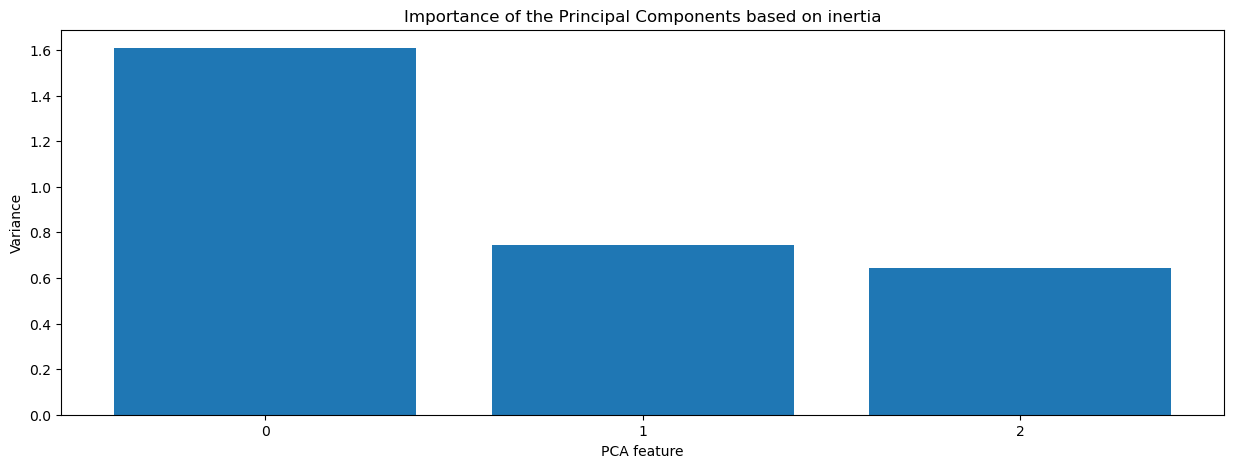

In [96]:
x=df_PMO.drop(columns=['SoC', 'TEMP', 'RHAMB'])
b.plot_pca(x,None)

In [97]:
# Calculate PCA with 2 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal_Df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

In [98]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(principal_Df)
principal_Df_PMO = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [99]:
df_PMO=df_PMO.reset_index()
df_PMO=pd.concat([df_PMO,principal_Df_PMO ], axis=1)
df_PMO=df_PMO.set_index('date')
df_PMO

OPC1      OPC2          OPC3       TEMP        SoC  \
date                                                                           
2015-09-09 11:00:00   8.996667  6.451667  0.000000e+00  85.300000  12.000000   
2015-09-09 11:01:00   8.990158  6.609252  0.000000e+00  85.332058  12.678686   
2015-09-09 11:02:00   8.983335  6.708722  0.000000e+00  85.337670  12.248142   
2015-09-09 11:03:00   8.975833  6.775617  0.000000e+00  85.334365  11.946789   
2015-09-09 11:04:00   8.966951  6.820627  0.000000e+00  85.319278  11.437837   
...                        ...       ...           ...        ...        ...   
2016-02-22 10:54:00  25.011769  4.198858  6.168891e-24  46.470497  38.056095   
2016-02-22 10:55:00  24.799172  4.198858  6.168818e-24  46.501210  37.639497   
2016-02-22 10:56:00  24.588622  4.198858  6.168756e-24  46.529220  37.554024   
2016-02-22 10:57:00  24.380176  4.198857  6.168702e-24  46.555215  37.565629   
2016-02-22 10:58:00  24.173646  4.198857  6.168657e-24  46.577219  37.637989   

                         RHAMB       pc1       pc2  
date                                                
2015-09-09 11:00:00   8.700000 -6.723452  0.627024  
2015-09-09 11:01:00   8.591357 -6.666015  0.493972  
2015-09-09 11:02:00   8.437764 -6.632172  0.408752  
2015-09-09 11:03:00   8.362105 -6.612003  0.350113  
2015-09-09 11:04:00   8.262697 -6.601840  0.308911  
...                        ...       ...       ...  
2016-02-22 10:54:00  24.768374  6.608762  9.781144  
2016-02-22 10:55:00  24.630213  6.419781  9.684313  
2016-02-22 10:56:00  24.529944  6.232620  9.588414  
2016-02-22 10:57:00  24.477448  6.047329  9.493473  
2016-02-22 10:58:00  24.353754  5.863742  9.399405  

[207992 rows x 8 columns]

In [100]:
## Saving the modified dataframe 

df_O3.to_pickle(root_path+"\df_O3_1.pkl")
df_O3=pd.read_pickle(root_path+"\df_O3_1.pkl")

df_O3_NO.to_pickle(root_path+"\df_O3_NO_1.pkl")
df_O3_NO=pd.read_pickle(root_path+"\df_O3_NO_1.pkl")

df_PM.to_pickle(root_path+"\df_PM_1.pkl")
df_PM=pd.read_pickle(root_path+"\df_PM_1.pkl")

df_PMO.to_pickle(root_path+"\df_PMO_1.pkl")
df_PMO=pd.read_pickle(root_path+"\df_PMO_1.pkl")

df_hppcf.to_pickle(root_path+"\df_hppcf_1.pkl")
df_hppcf=pd.read_pickle(root_path+"\df_hppcf_1.pkl")

### Cheking if the Feature (sensor Reading)  are linearly or non linearly related to decide the which method of dimensionality reduction is suitable. 

In [ ]:
def pair_plot(df):
  df=df.reset_index(drop=True)
  return sns.pairplot(df)

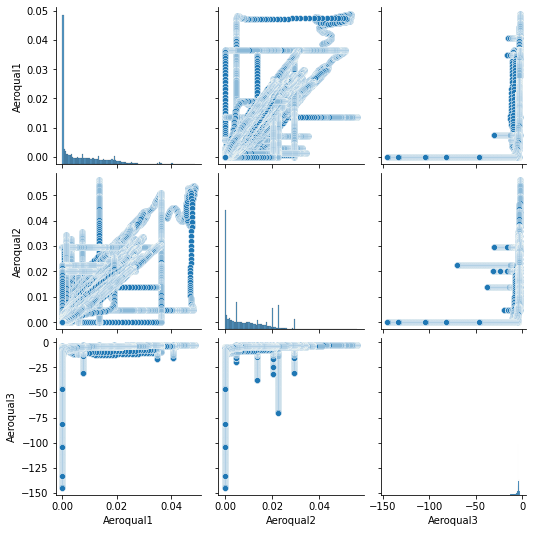

In [ ]:
pair_plot(df_O3[['Aeroqual1','Aeroqual2','Aeroqual3']])

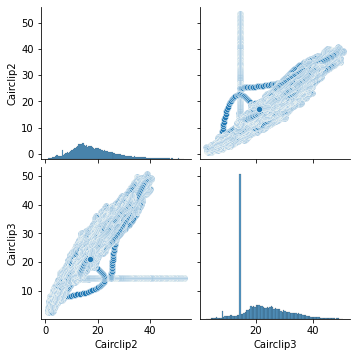

In [ ]:
pair_plot(df_O3_NO[['Cairclip2', 'Cairclip3']])

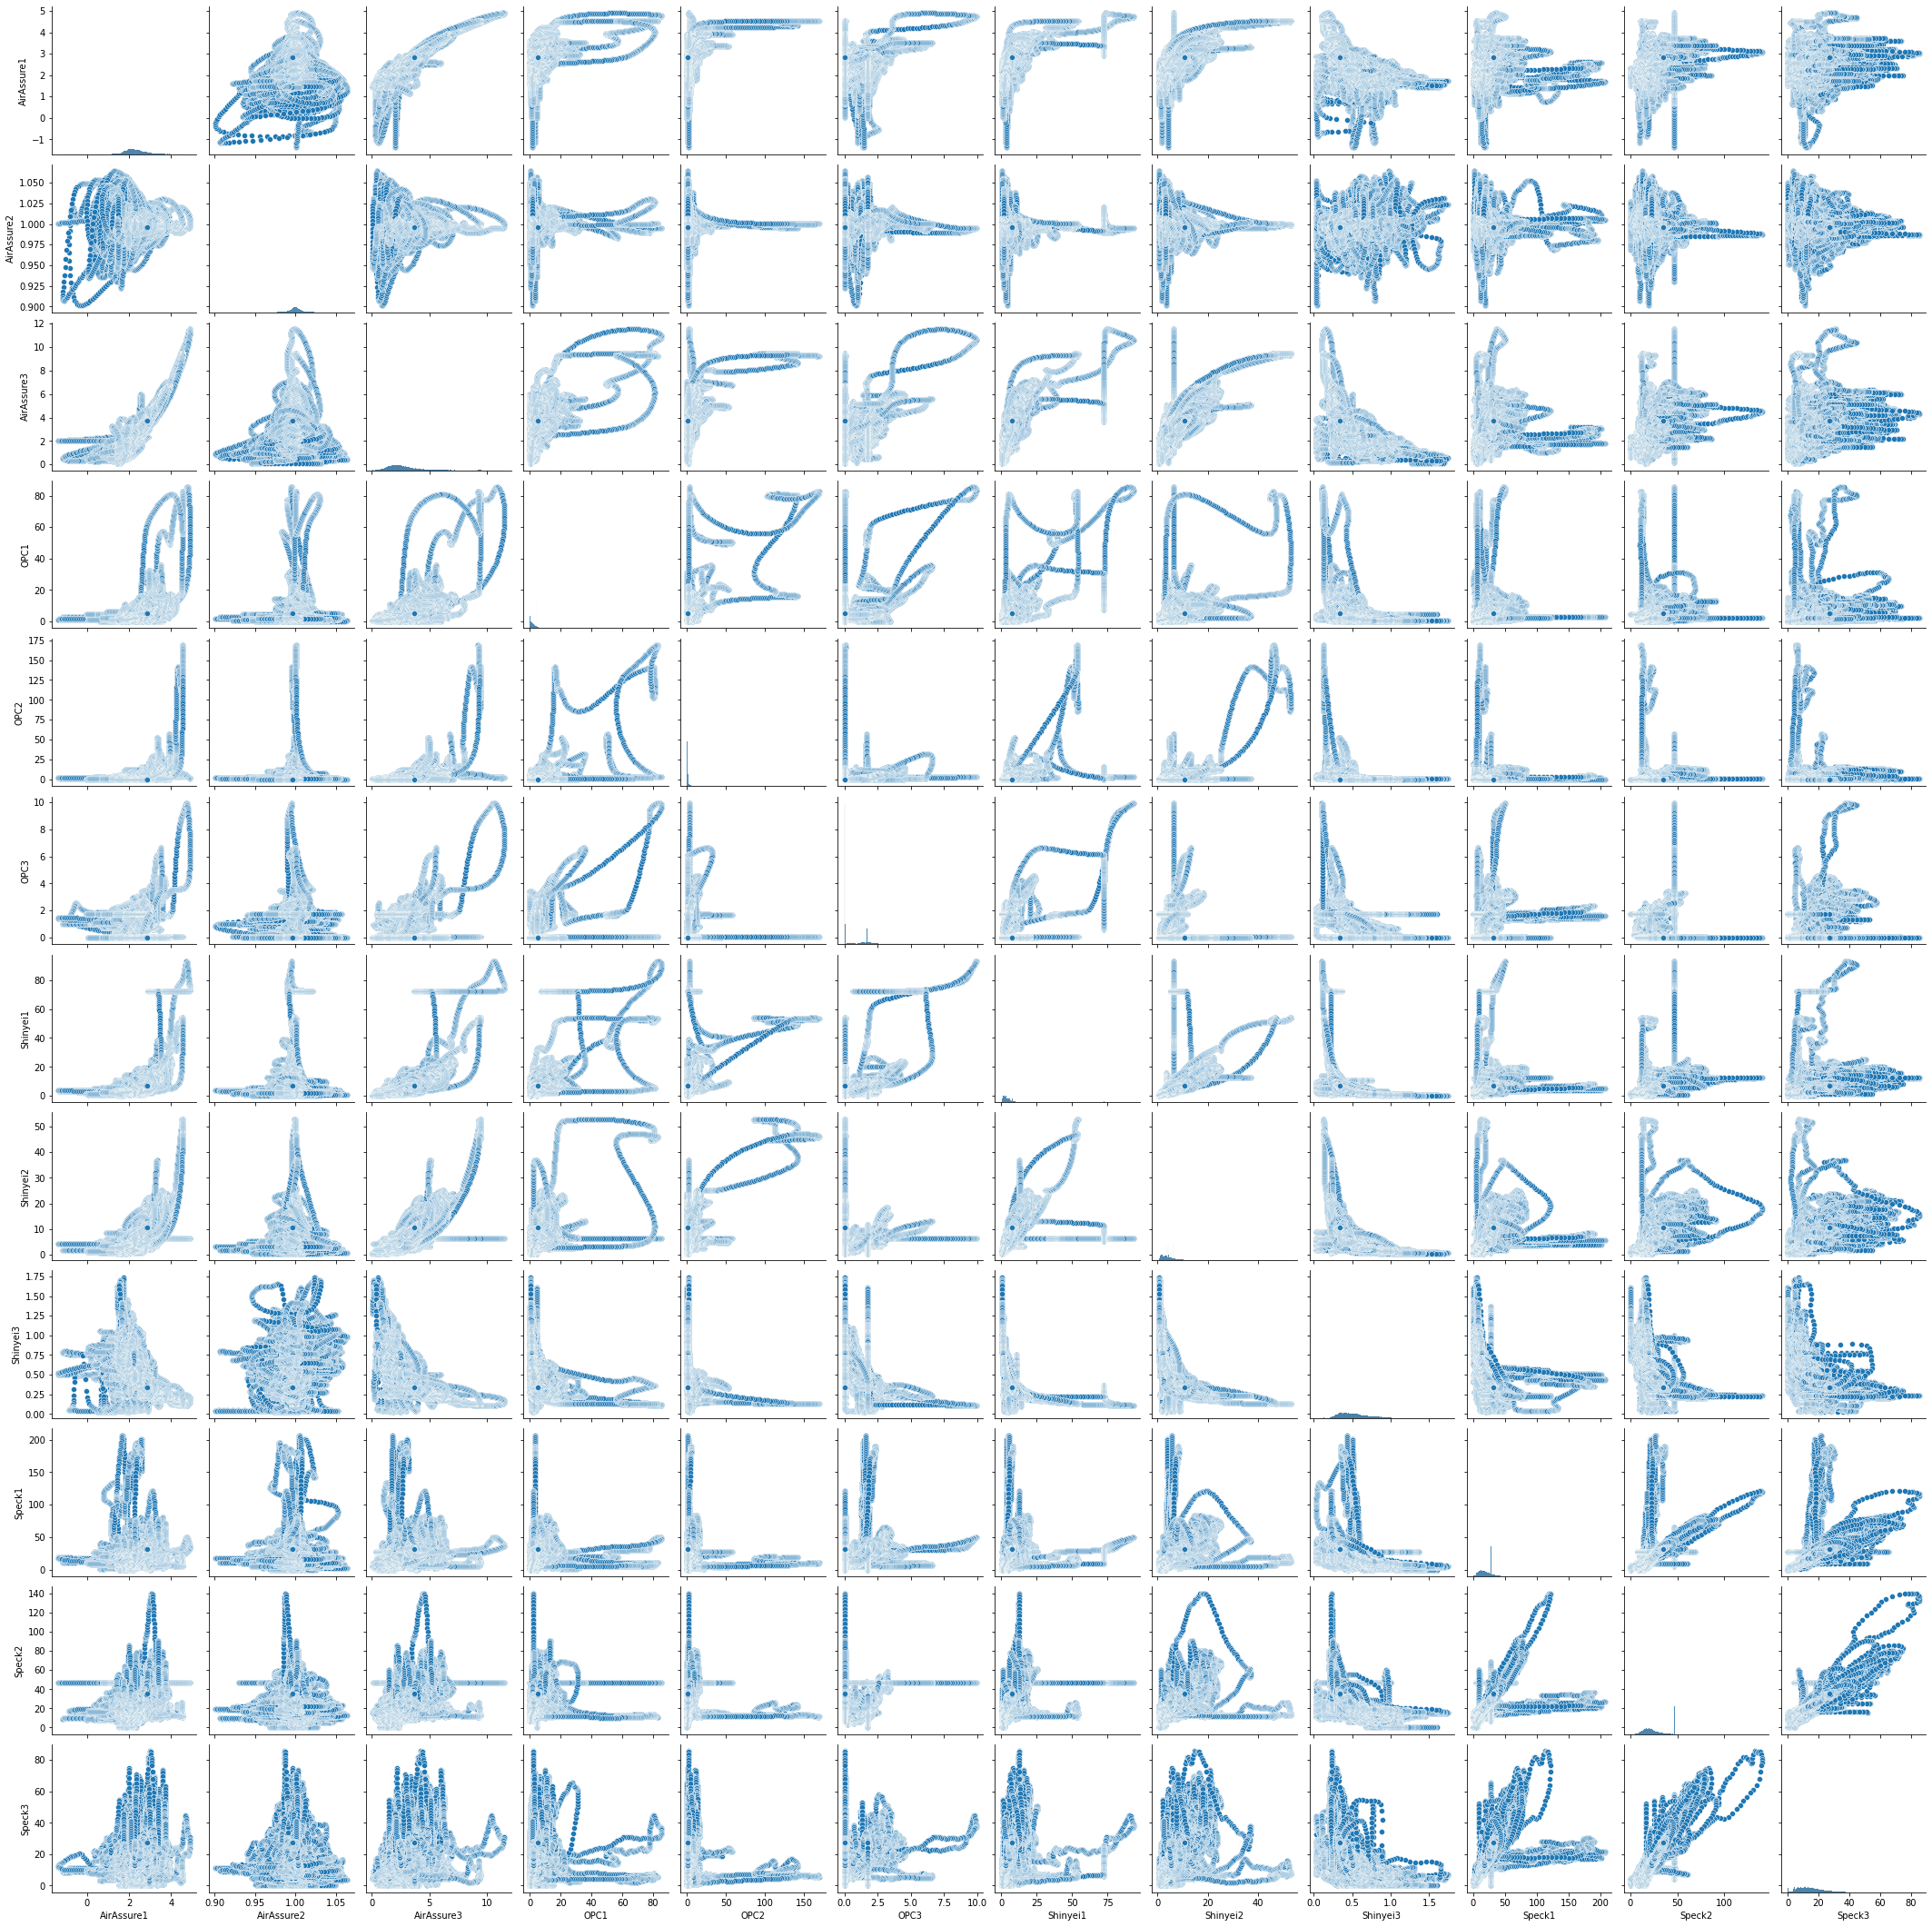

In [ ]:
pair_plot(df_PM[['AirAssure1', 'AirAssure2', 'AirAssure3', 'OPC1', 'OPC2', 'OPC3', 'Shinyei1', 'Shinyei2', 'Shinyei3', 'Speck1',
       'Speck2', 'Speck3']])

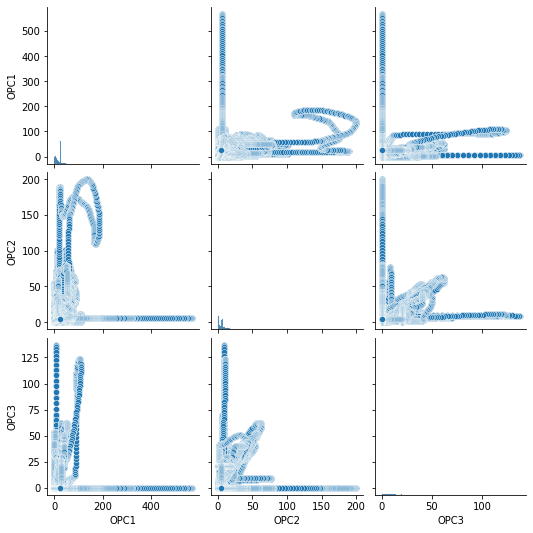

In [ ]:
pair_plot(df_PMO[['OPC1', 'OPC2', 'OPC3']])

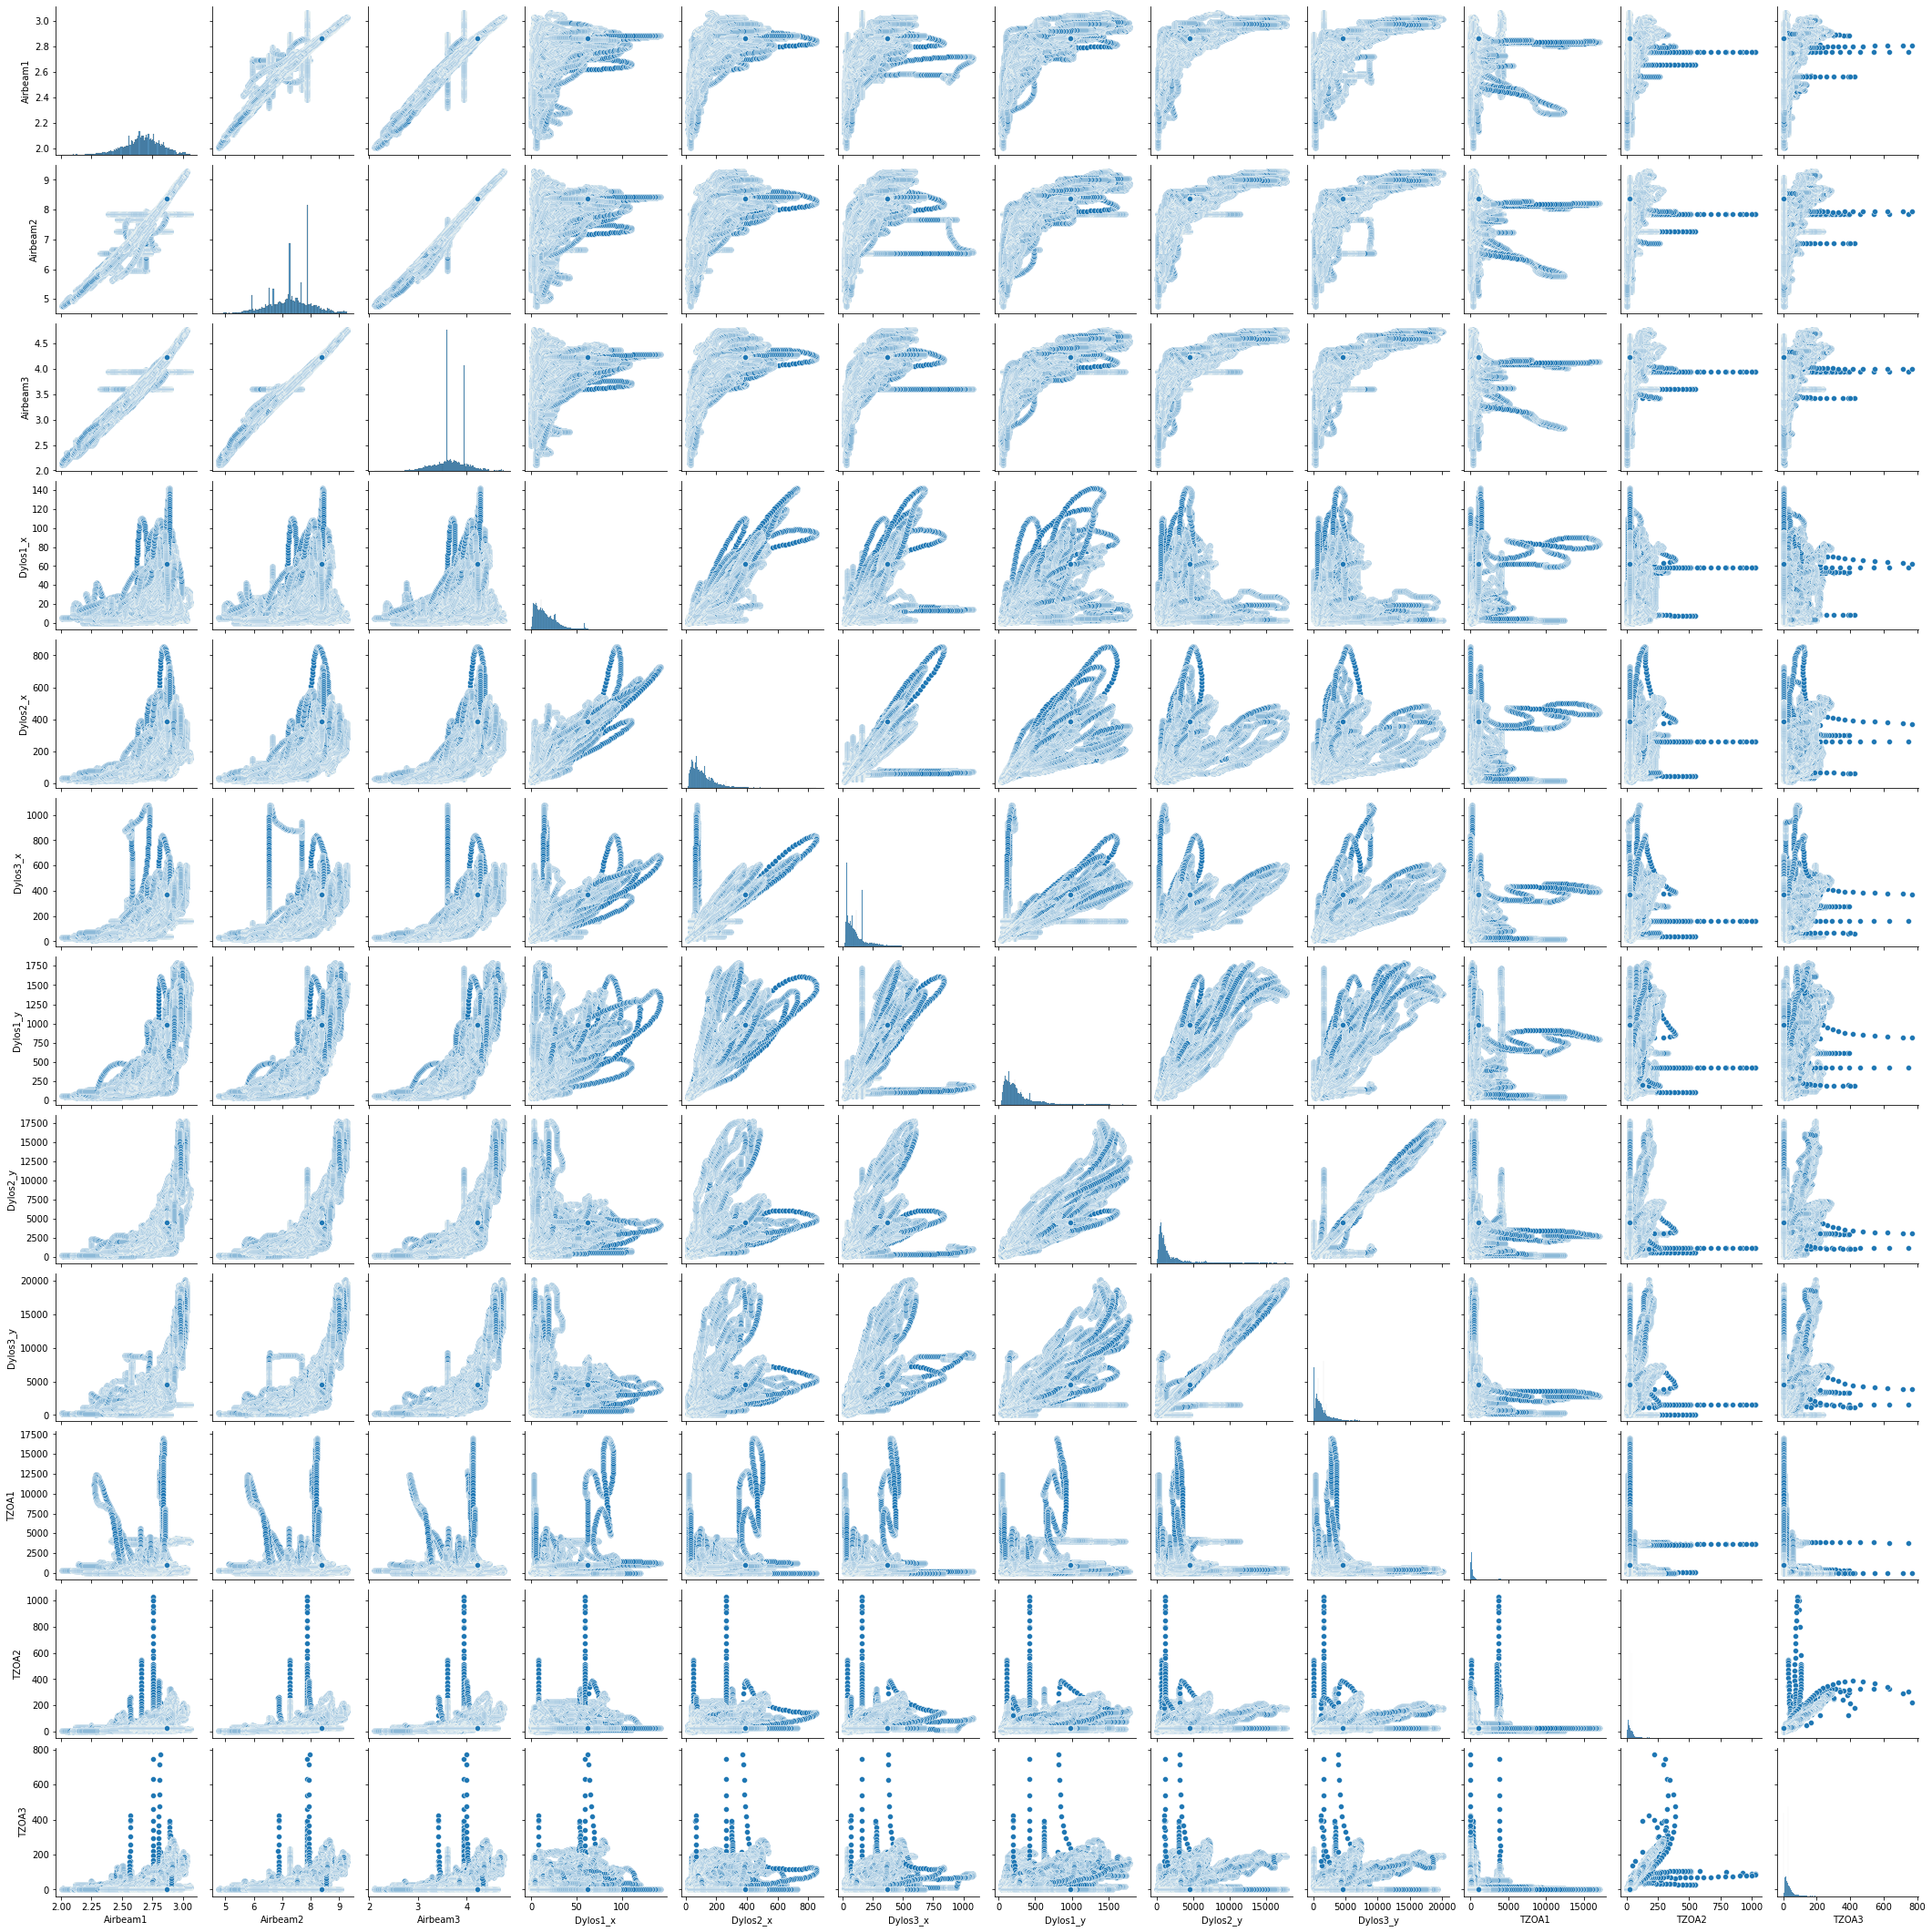

In [ ]:
pair_plot(df_hppcf[['Airbeam1', 'Airbeam2', 'Airbeam3','Dylos1_x', 'Dylos2_x', 'Dylos3_x', 'Dylos1_y', 'Dylos2_y', 'Dylos3_y', 'TZOA1','TZOA2', 'TZOA3' ]])

As most of the data shows a combination of linear & non -linear relationship we need to perform both ways of identifying the outliers using PCA based approach & Auto Encoder.

# Modeling 

### In this step, I will perform the following learning algorithms to detect anomalies.

#### Benchmark model: Interquartile Range (IQR)
#### K-Means clustering- Eucledian
#### K-Means clustering- Mahalobnis
#### Isolation Forest
#### AutoEncoder

In [101]:
class model:

  def IQR_env(self,df,i):
    q1_pc1, q3_pc1 = df[i].quantile([0.25, 0.75])
    iqr_pc1 = q3_pc1 - q1_pc1
    # Calculate upper and lower bounds for outlier for pc1
    lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
    upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
    # Filter out the outliers from the pc1
    df['anomaly_'+str(i)] = ((df[i]>upper_pc1) | (df[i]<lower_pc1)).astype('int')
    b = df[df['anomaly_'+str(i)] == 1] #anomaly
    plt.figure(figsize=(18,6))
    plt.plot(df[i], color='blue', label='Normal')
    plt.plot(b[i], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(str(i)+ '  Anomalies')
    plt.show()

  # Calculate IQR for the 1st principal component (pc1)
  def IQR(self, df, i, r=None):
    q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
    iqr_pc1 = q3_pc1 - q1_pc1
    # Calculate upper and lower bounds for outlier for pc1
    lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
    upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
    # Filter out the outliers from the pc1
    df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int') 
    b = df[df['anomaly_pc1'] == 1] #anomaly
    plt.figure(figsize=(18,6))
    plt.plot(df[i], color='blue', label='Normal')
    plt.plot(b[i], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(str(i)+ '  Anomalies')
    plt.show()
    self.IQR_env(df,r)

    # Calculate Kmeans
  def kmeans(self, df, i, q):
        kmeans = KMeans(n_clusters=2, random_state=42)
        kmeans.fit(df[['pc1','pc2']].values.reshape(-1, 1))
        labels = kmeans.predict(df[['pc1','pc2']].values.reshape(-1, 1))
        unique_elements, counts_elements = np.unique(labels, return_counts=True)
        clusters = np.asarray((unique_elements, counts_elements))
        def Euclidean(x, y):
              return np.linalg.norm(x-y)
            # Write a function that calculates distance between each point and the centroid of the closest cluster
        def getDistanceByPoint(data, model):
            distance = []
            for i in range(0,len(data)):
                Xa = tf.Variable(np.array(data.reset_index().drop(columns=['date']).loc[i]), dtype = tf.float32)
                Xb = tf.Variable(model.cluster_centers_[model.labels_[i]-1], dtype = tf.float32)
                distance.append(Euclidean(Xa, Xb))
            return pd.Series(distance, index=data.index)
        # Assume that 1% of the entire data set are anomalies 
        outliers_fraction = 0.01
        # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
        distance = getDistanceByPoint(df[['pc1','pc2']], kmeans)
        # number of observations that equate to the 1% of the entire data set
        number_of_outliers = int(outliers_fraction*len(distance))
        # Take the minimum of the largest 1% of the distances as the threshold
        threshold = distance.nlargest((number_of_outliers)).min()
        # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
        df['anomaly1_Kmeans'] = (distance >= threshold).astype(int)
        b = df[df['anomaly1_Kmeans'] == 1] #anomaly
        plt.figure(figsize=(18,6))
        plt.plot(df[i], color='blue', label='Normal')
        plt.plot(b[i], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
        plt.xlabel('Date and Time')
        plt.ylabel('Sensor Reading')
        plt.title(str(a)+ '  Anomalies')
        plt.show()
        self.IQR_env(df,q)

  def Isolation_forest(self, df, i,q):
    outliers_fraction = 0.01
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(df[['pc1','pc2']].values) 
    df['anomaly2_isolation_forest'] = (model.predict(df[['pc1','pc2']].values))
    b =df.loc[df['anomaly2_isolation_forest'] == -1] #anomaly
    plt.figure(figsize=(18,6))
    plt.plot(df[i], color='blue', label='Normal')
    plt.plot(b[i], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(str(a)+ '  Anomalies')
    plt.legend(loc='best')
    self.IQR_env(df,q)

  def Mahalobnis(self, df, i, q):
      kmeans = KMeans(n_clusters=2, random_state=42)
      kmeans.fit(df[['pc1','pc2']].values.reshape(-1, 1))
      labels = kmeans.predict(df[['pc1','pc2']].values.reshape(-1, 1))
      unique_elements, counts_elements = np.unique(labels, return_counts=True)
      clusters = np.asarray((unique_elements, counts_elements))
      def getDistanceByPoint(data, model):
          Xb = pd.DataFrame(model.cluster_centers_[model.labels_-1])
          df=pd.concat([data.reset_index().drop(columns=['date']), Xb], axis=1)
          df=df.dropna()
          df1=df[df[0]==(model.cluster_centers_[model.labels_[0]])[0]].dropna().reset_index(drop=True)
          df2=df[df[0]==(model.cluster_centers_[model.labels_[1]])[0]].dropna().reset_index(drop=True)
          covariance1  = np.cov(df1[['pc1','pc2']] , rowvar=False)
          covariance2  = np.cov(df2[['pc1','pc2']] , rowvar=False)
          covariance_pm1 = np.linalg.matrix_power(covariance1, -1)
          covariance_pm2 = np.linalg.matrix_power(covariance2, -1)
          centerpoint1 = np.mean(df1[0] , axis=0)
          centerpoint2 = np.mean(df2[0] , axis=0)
          distances = []
          for i in range(len(data)):
            if df[0][i]==df[0][1]:
              p1 = df[['pc1','pc2']].iloc[i]
              p2 = centerpoint1
              distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
            else:
              p1 = df[['pc1','pc2']].iloc[i]
              p2 = centerpoint2
              distance = (p1-p2).T.dot(covariance_pm2).dot(p1-p2)
            distances.append(distance)
          return pd.Series(distances , index=data.index)
      distances= getDistanceByPoint(df[['pc1','pc2']], kmeans)
      outliers_fraction = 0.01
      # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
      # number of observations that equate to the 1% of the entire data set
      number_of_outliers = int(outliers_fraction*len(distances))
      # Take the minimum of the largest 1% of the distances as the threshold
      threshold = distances.nlargest((number_of_outliers)).min()
      # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
      df['anomaly1_Kmeans'] = pd.DataFrame((distances > threshold).astype(int)).values
      b = df[df['anomaly1_Kmeans'] == 1] #anomaly
      plt.figure(figsize=(18,6))
      plt.plot(df[i], color='blue', label='Normal')
      plt.plot(b[i], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
      plt.xlabel('Date and Time')
      plt.ylabel('Sensor Reading')
      plt.title(str(a)+ '  Anomalies')
      plt.show()
      self.IQR_env(df,q)

In [102]:
c=model()

# Using Mahalobnis distance to measure the anamolies:- 

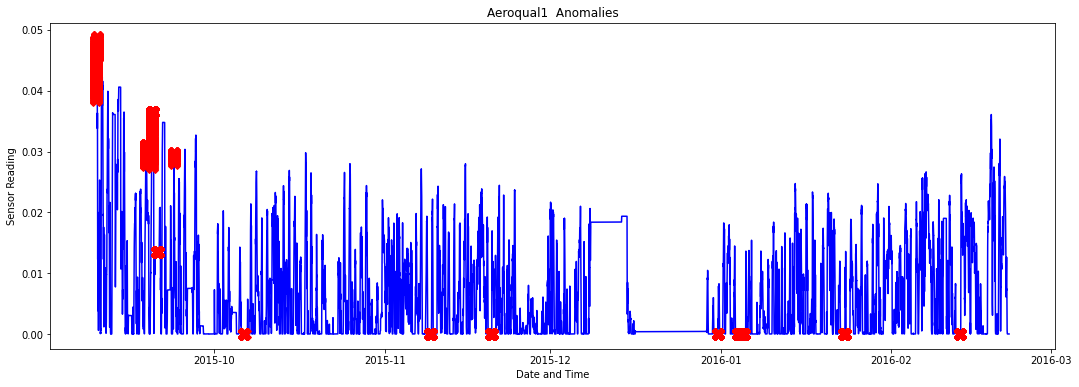

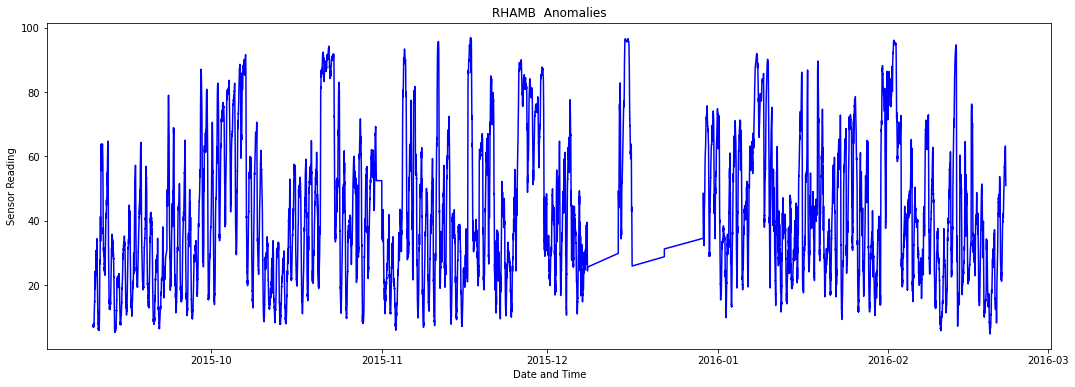

In [ ]:
a='Aeroqual1'
b='RHAMB'
c.Mahalobnis(df_O3, a, b)

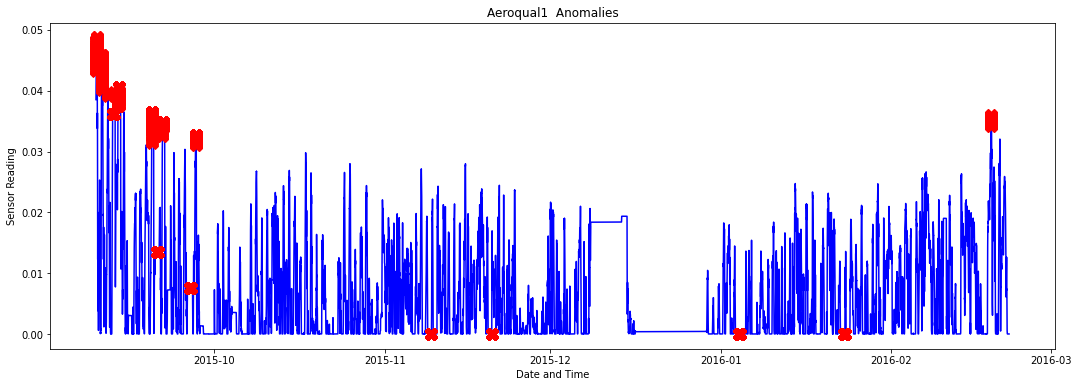

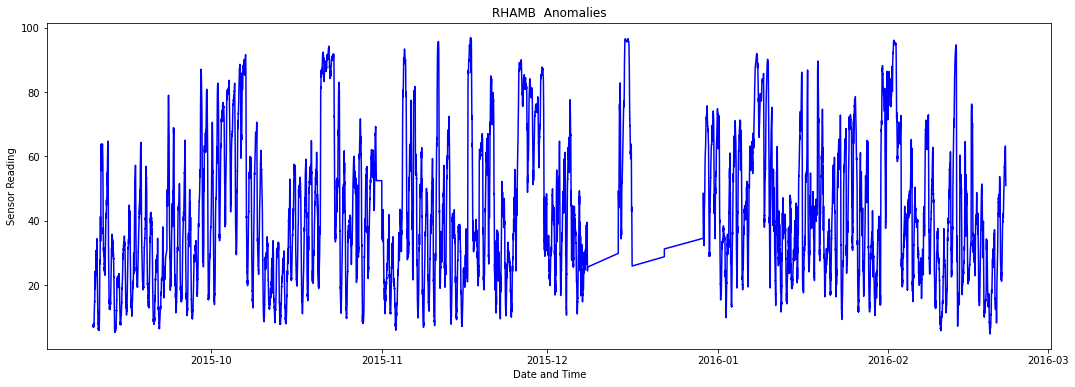

In [ ]:
a='Aeroqual1'
b='RHAMB'
c.kmeans(df_O3, a, b)

## Using the BHT metrics for checking the anamoly 

In [103]:
pip install pyod

     -------------------------------------- 150.0/150.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184165 sha256=21fd640ae924f144d36436894654a6eb63f20803287ee168b43009497ed41b4e
  Stored in directory: c:\users\prath\appdata\local\pip\cache\wheels\83\b7\18\b5ea389c5d1e69456ea53bc05fda0339d6b845cbdeb3a39029
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


In [104]:
! pip install pythresh

     -------------------------------------- 197.0/197.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.6/2.6 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pythresh: filename=pythresh-0.3.0-py3-none-any.whl size=213098 sha256=d4dc48cb95ff838d1aeda19a1b3eec8057d53f050feda9178e33205097ec9978
  Stored in directory: c:\users\prath\appdata\local\pip\cache\wheels\4d\4f\43\885c5d554ae0ac41ef70ec340095e7a607d7e3f6214df75dd3
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395139 sha256=2972a9e9abbf91f3af1a82f4c9fb9e1cb78a19f5d6ecf1c0a55625afcbb8d00b
  Stored in directory: c:\users\prath\appdata\local\pip\cache\wheels\ff\33\66\bea0dcd0babb2fa8fb4413f8bfeb064303f37d3cd7b6b451ec
Successfully built pythresh pyclustering


In [105]:
from pyod.models.pca import PCA as PCA_out
from pythresh.thresholds.dsn import DSN

clf = PCA_out(n_components=2)
clf.fit(df_O3[['Aeroqual1','Aeroqual2','Aeroqual3']])
scores = clf.decision_scores_

thres = DSN(metric='BHT')
labels = thres.eval(scores)

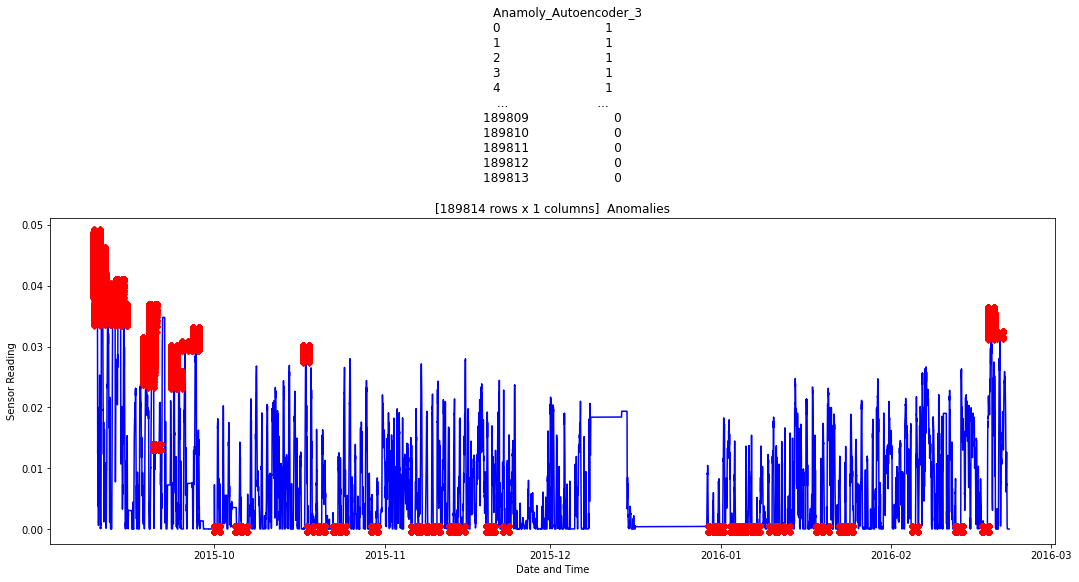

In [ ]:
a=pd.DataFrame(labels).astype(int)
a=a.rename(columns={0:'Anamoly_Autoencoder_3'})
df_O3=pd.concat([df_O3.reset_index(),a], axis=1)
df_O3=df_O3.set_index('date')
b = df_O3[df_O3['Anamoly_Autoencoder_3'] == 1] #anomaly
plt.figure(figsize=(18,6))
plt.plot(df_O3['Aeroqual1'], color='blue', label='Normal')
plt.plot(b['Aeroqual1'], linestyle='none', marker='X', color='red', markersize=8, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title(str(a)+ '  Anomalies')
plt.show()

## Using the Autoencoder for Anamoly Detectition

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
train=df_O3[['Aeroqual1','Aeroqual2','Aeroqual3']].groupby(pd.Grouper(freq='15min')).sum()

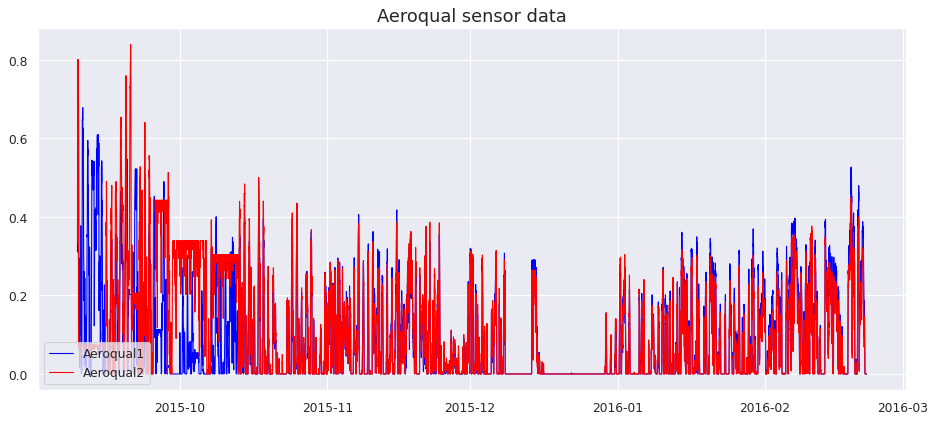

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Aeroqual1'], label='Aeroqual1', color='blue', animated = True, linewidth=1)
ax.plot(train['Aeroqual2'], label='Aeroqual2', color='red', animated = True, linewidth=1)


plt.legend(loc='lower left')
ax.set_title('Aeroqual sensor data', fontsize=16)
plt.show()

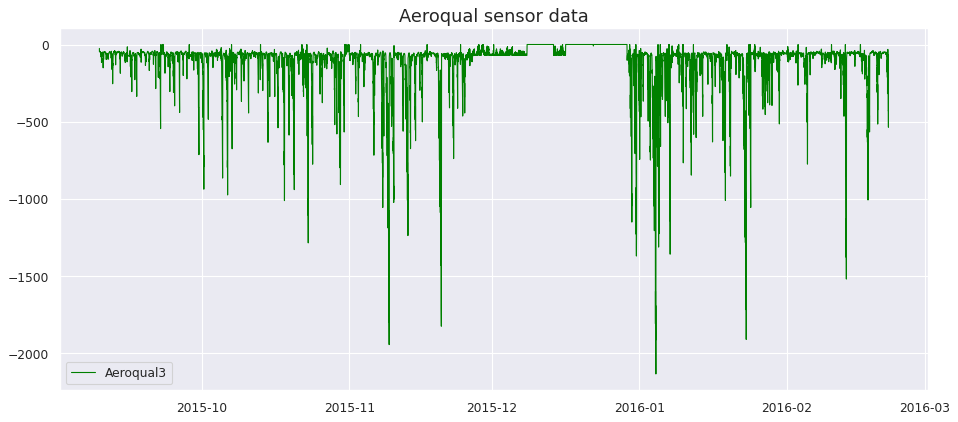

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Aeroqual3'], label='Aeroqual3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Aeroqual sensor data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(train)

In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)

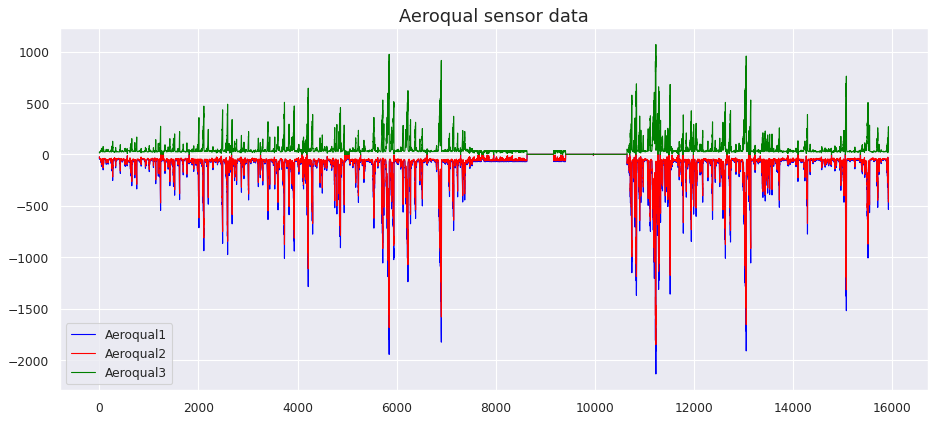

In [ ]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Aeroqual1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Aeroqual2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Aeroqual3', color='green', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Aeroqual sensor data', fontsize=16)
plt.show()

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train
print("Training data shape:", X_train.shape)
X_test = X_test
print("Test data shape:", X_test.shape)

Training data shape: (15926, 1, 3)
Test data shape: (15926, 1, 3)


In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
1513/1513 [==============================] - 18s 6ms/step - loss: 0.0921 - val_loss: 0.0240
Epoch 2/100
1513/1513 [==============================] - 7s 5ms/step - loss: 0.0332 - val_loss: 0.0164
Epoch 3/100
1513/1513 [==============================] - 8s 5ms/step - loss: 0.0305 - val_loss: 0.0152
Epoch 4/100
1513/1513 [==============================] - 7s 5ms/step - loss: 0.0297 - val_loss: 0.0148
Epoch 5/100
1513/1513 [==============================] - 9s 6ms/step - loss: 0.0287 - val_loss: 0.0135
Epoch 6/100
1513/1513 [==============================] - 11s 7ms/step - loss: 0.0266 - val_loss: 0.0143
Epoch 7/100
1513/1513 [==============================] - 7s 5ms/step - loss: 0.0227 - val_loss: 0.0137
Epoch 8/100
1513/1513 [==============================] - 8s 5ms/step - loss: 0.0171 - val_loss: 0.0087
Epoch 9/100
1513/1513 [==============================] - 7s 5ms/step - loss: 0.0105 - val_loss: 0.0057
Epoch 10/100
1513/1513 [==============================] - 8s 5ms/step -

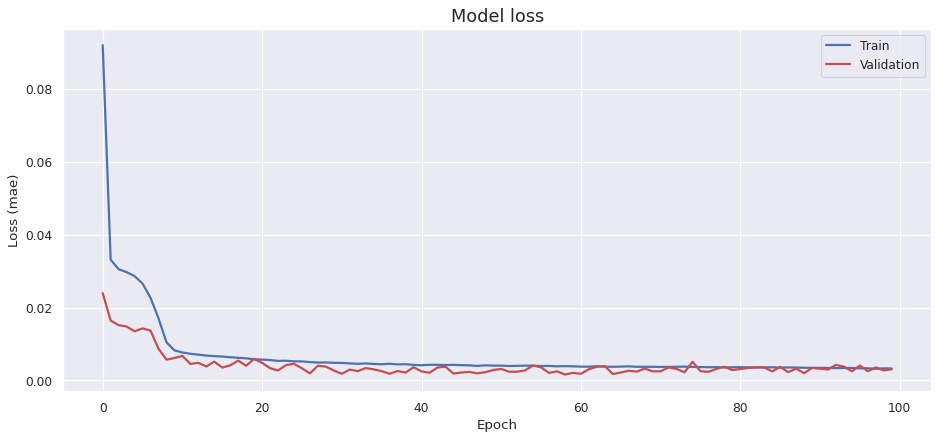

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

498/498 [==============================] - 4s 3ms/step


(0.0, 0.5)

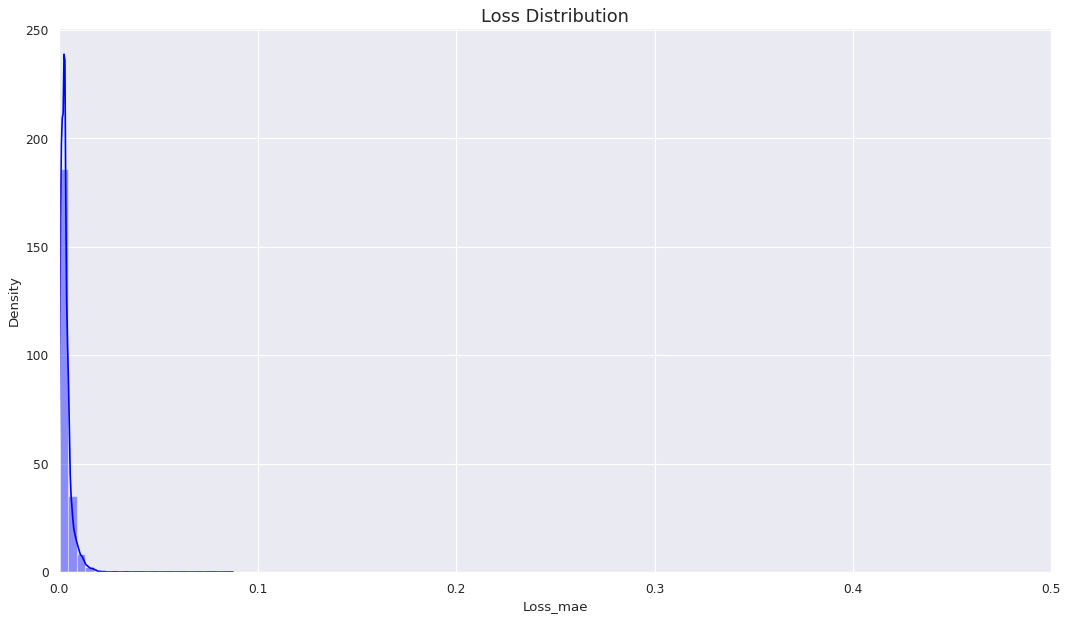

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
test=train
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
# number of observations that equate to the 1% of the entire data set
number_of_outliers = int(outliers_fraction*len(scored))
# Take the minimum of the largest 1% of the distances as the threshold
threshold = scored['Loss_mae'].nlargest((number_of_outliers)).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
# df['anomaly1_Kmeans'] = pd.DataFrame((distances > threshold).astype(int)).values
# b = df[df['anomaly1_Kmeans'] == 1] #anomaly
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

498/498 [==============================] - 1s 2ms/step


Loss_mae  Threshold  Anomaly
date                                             
2015-09-09 11:30:00  0.007105   0.014182    False
2015-09-09 11:45:00  0.007163   0.014182    False
2015-09-09 12:00:00  0.005792   0.014182    False
2015-09-09 12:15:00  0.004938   0.014182    False
2015-09-09 12:30:00  0.004922   0.014182    False

In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

498/498 [==============================] - 2s 3ms/step


<Axes: xlabel='date'>

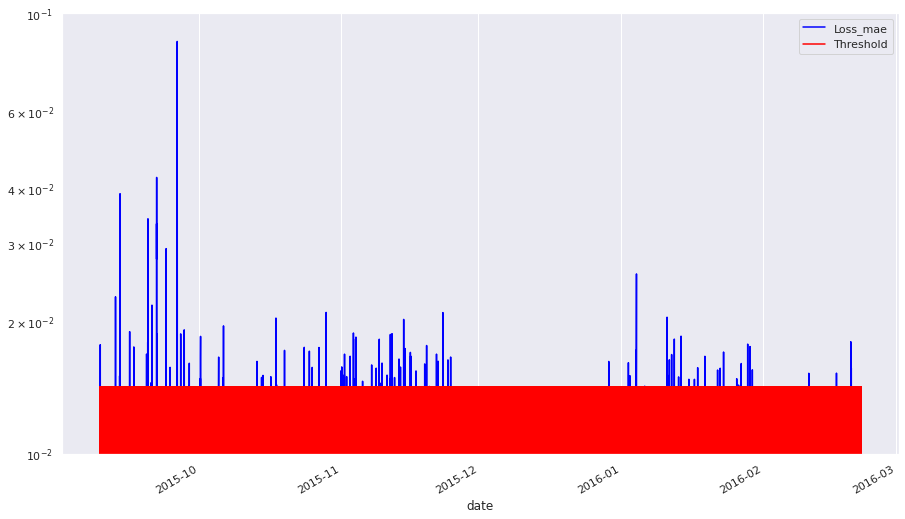

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(15,9), ylim=[1e-2,0.1], color=['blue','red'])

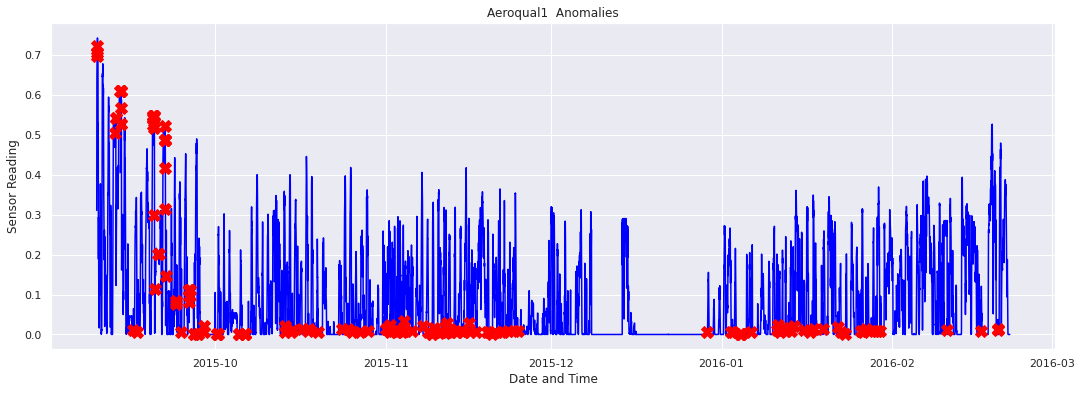

In [ ]:
train['Anamoly'] = ((np.mean(np.abs(X_pred-Xtest), axis = 1)).values >= threshold).astype(int)
b = train[train['Anamoly'] == 1] #anomaly
plt.figure(figsize=(18,6))
plt.plot(train['Aeroqual1'], color='blue', label='Normal')
plt.plot(b['Aeroqual1'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title(str('Aeroqual1')+ '  Anomalies')
plt.show()

### Buidling a CNN Auto Encoder

Build a model We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 288 and num_features is 1.

In [3]:
import keras as keras 

model = keras.Sequential(
    [
        layers.Input(shape=(96, X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
# create the autoencoder model
model.compile(optimizer='adam', loss='mae')
model.summary()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=40,
    validation_split=0.1,
    # callbacks=[
    #     keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    # ],
).history

Epoch 1/50


ValueError: ignored

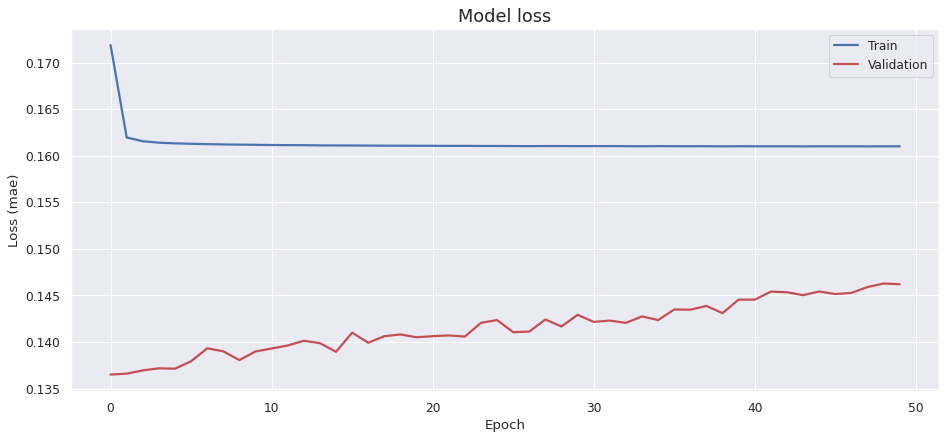

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

498/498 [==============================] - 1s 3ms/step


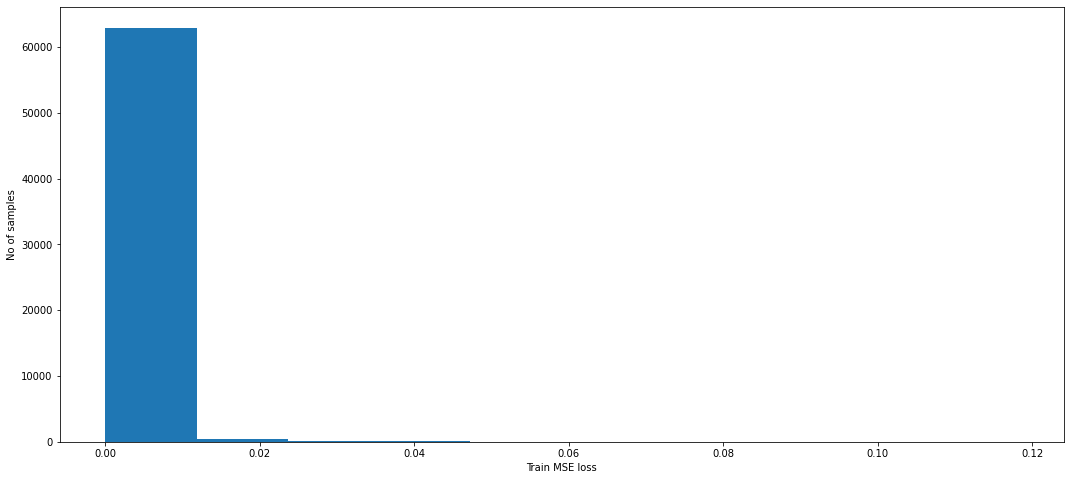

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

498/498 [==============================] - 1s 3ms/step


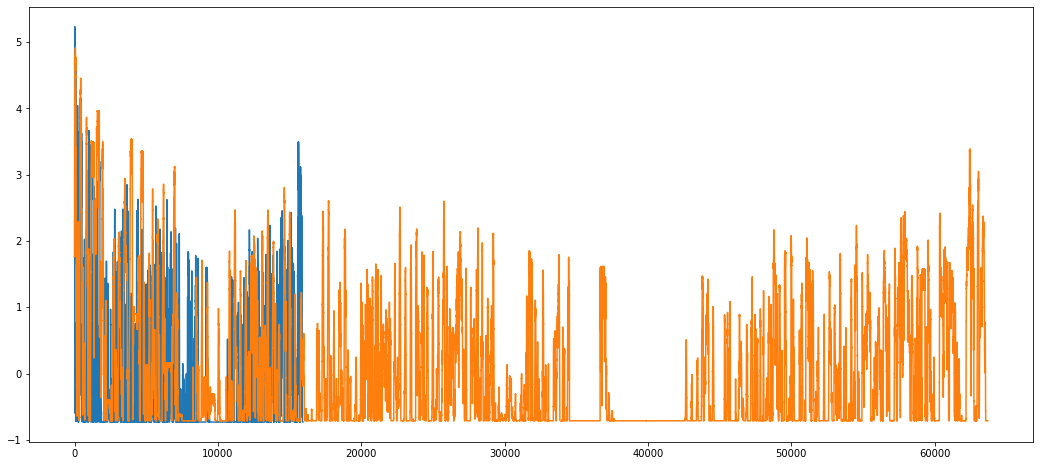

In [ ]:
# Checking how the first sequence is learnt
x_train_pred = model.predict(x_train)
plt.plot((x_train).reshape(-1))
plt.plot(x_train_pred.reshape(-1))
plt.show()

## Building the ML algorithms for  real time (continuous processing)

#### We will be  using PyOD and PySAD

In [4]:
import os
import numpy as np
from scipy.io import loadmat
from pyod.models.hbos import HBOS
from pysad.models.integrations import ReferenceWindowModel
from pysad.utils import ArrayStreamer
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.probability_calibration import GaussianTailProbabilityCalibrator
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'pysad'